In [1]:
#!pip install scikit-learn

In [3]:
import gzip 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

def test_gpus():
    print(torch.cuda.is_available())
    print(torch.__version__)

def load_data_to_train(): 
    data_path = ('/home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600.npy.gz')
    print('Loading from:\n', data_path)
    with gzip.open(data_path, 'rb') as f:
        np_data = np.load(f, allow_pickle=True)
    return np_data.item()['meta'], np_data.item()['lcs'], np_data

def save_data(meta, lcs, data,
    data_path = 'data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_6PP.npy.gz'):
    print('Saving to:\n', data_path)
    data.item()['meta'] = meta
    data.item()['lcs'] = lcs
    with gzip.open(data_path, 'wb') as f:
        np.save(f, data)    
    print('Data saved successfully.')

def load_new_validated_pp():
    pp_path = 'data/inter/Validated_OGLExGaiaDR3.csv'
    df = pd.read_csv(pp_path)
    return df

def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return [x for x in data if lower_bound <= x <= upper_bound]


def compare_frequency(s1, s2, s3, feature = "Period", clean = True): 
    
    if clean:
        s1 = remove_outliers(s1)
        s2 = remove_outliers(s2)
        s3 = remove_outliers(s3)

    plt.figure(figsize=(5,5))

    # Plot histograms
    plt.hist(s1, bins=100, alpha=0.5, label=feature +' 1')
    plt.hist(s2, bins=100, alpha=0.5, label= feature +' 2')
    plt.hist(s3, bins=100, alpha=0.5, label='Final ' + feature)

    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')
    plt.title('Comparison of Histograms')
    plt.show()


def basic_histogram(s1, title='Delta of Teff'): 
    plt.figure(figsize=(5,5))

    # Plot histograms
    plt.hist(s1, bins=50, alpha=0.5)

    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

def update_values(df, feature="teff_val"):
    condition_orig_is_nan = df[feature+'_orig'].isna()
    condition_new_is_nan = df[feature+'_new'].isna()

    df[feature] = np.where(
        condition_orig_is_nan, 
        df[feature+'_new'],
        np.where(condition_new_is_nan, df[feature+'_orig'], df[feature+'_new'])
    )

    return df



In [4]:
columns_original = ['Type', 'OGLE_id', 'teff_val','Period', 'abs_Gmag', '[Fe/H]_J95', 'radius_val']
columns_gaia3 = ["OGLE-ID", "Teff", "Period", "GMAG_x", "[Fe/H]", "Rad", "logg"]

# paper metadata

In [4]:
meta1, lcs, data = load_data_to_train()
meta1.head()

Loading from:
 data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600.npy.gz


,OGLE_id,RA,Dec,Type,subType,GAIA_source_id,parallax,abs_Gmag,phot_g_mean_mag,phot_bp_mean_mag,...,radius_val,lum_val,SNR,I,abs_Imag,V_I,V,Period,[Fe/H]_J95,[Fe/H]_ZW
0,OGLE-LMC-ACEP-019,75.823792,-68.825974,ACEP,F,4661305092779097984,-0.0157,4.636482,17.854393,17.690159,...,NaN,NaN,12.802861,17.414000,4.636482,0.477001,NaN,0.909406,NaN,NaN
1,OGLE-LMC-ACEP-028,78.291748,-68.769974,ACEP,1O,4658358809586143104,NaN,NaN,18.758457,18.465401,...,NaN,NaN,5.868115,17.573999,NaN,0.748001,NaN,0.599253,NaN,NaN
2,OGLE-LMC-ACEP-019,75.823792,-68.825974,ACEP,F,4661305092779097984,-0.0157,4.636482,17.854393,17.690159,...,NaN,NaN,12.802861,17.414000,4.636482,0.477001,NaN,0.909406,NaN,NaN
3,OGLE-LMC-ACEP-074,90.688248,-70.758667,ACEP,F,5278596793422657920,-0.0511,3.173356,17.454035,17.706608,...,NaN,NaN,7.737402,16.889000,3.173356,0.662001,NaN,1.533225,NaN,NaN
4,OGLE-LMC-ACEP-015,75.247169,-69.556915,ACEP,1O,4655253410764410496,0.0134,3.802980,17.461372,17.628338,...,NaN,NaN,9.799247,16.962000,3.802980,0.625000,NaN,1.180879,NaN,NaN


In [5]:
meta1 = meta1[columns_original]
meta1.describe()


,teff_val,Period,abs_Gmag,[Fe/H]_J95,radius_val
count,44045.000000,65760.000000,62875.000000,528.000000,3409.000000
mean,4753.358887,67.679367,2.144422,-1.692803,2.818140
std,1325.471313,166.922623,1.986338,0.387042,1.559536
min,3252.669922,0.060624,-3.580621,-3.070000,0.510000
25%,3709.000000,0.574036,0.797206,-2.004500,1.560000
50%,4534.470215,1.888099,2.068410,-1.623500,2.580000
75%,5301.089844,30.848353,3.439986,-1.375750,3.980000
max,9644.000000,10000.000000,20.805693,-0.638000,17.320000


In [6]:
meta1 = meta1[meta1.abs_Gmag<15]
meta1.describe()

,teff_val,Period,abs_Gmag,[Fe/H]_J95,radius_val
count,43031.000000,62873.000000,62873.000000,516.000000,3409.000000
mean,4762.116699,63.785763,2.143829,-1.695919,2.818140
std,1330.136108,163.502289,1.983579,0.388296,1.559536
min,3252.669922,0.060624,-3.580621,-3.070000,0.510000
25%,3709.000000,0.580509,0.797206,-2.017500,1.560000
50%,4546.000000,1.888099,2.068410,-1.629500,2.580000
75%,5307.000000,27.360649,3.439616,-1.383000,3.980000
max,9644.000000,10000.000000,12.926695,-0.638000,17.320000


In [7]:
meta1 = meta1[meta1['Period']<1000]
meta1.describe()

,teff_val,Period,abs_Gmag,[Fe/H]_J95,radius_val
count,43016.000000,62858.000000,62858.000000,516.000000,3405.000000
mean,4762.127441,62.468948,2.144034,-1.695919,2.817720
std,1330.279297,123.862671,1.983594,0.388296,1.559839
min,3252.669922,0.060624,-3.580621,-3.070000,0.510000
25%,3709.000000,0.580292,0.797668,-2.017500,1.560000
50%,4546.000000,1.888099,2.068410,-1.629500,2.580000
75%,5307.000000,27.352522,3.440111,-1.383000,3.980000
max,9644.000000,977.469360,12.926695,-0.638000,17.320000


In [8]:
meta1.sort_values('radius_val', ascending=False)

,Type,OGLE_id,teff_val,Period,abs_Gmag,[Fe/H]_J95,radius_val
28803,ECL,OGLE-GD-ECL-05232,3660.000000,51.746441,0.252080,NaN,17.32
23297,ECL,OGLE-BLG-ECL-287376,4046.000000,17.020014,0.333000,NaN,12.14
33570,ELL,OGLE-BLG-ELL-014807,3792.419922,11.027345,0.958239,NaN,10.88
34781,ELL,OGLE-BLG-ELL-014807,3792.419922,11.027345,0.958239,NaN,10.88
34208,ELL,OGLE-BLG-ELL-014807,3792.419922,11.027345,0.958239,NaN,10.88
...,...,...,...,...,...,...,...
65755,T2CEP,OGLE-BLG-T2CEP-265,3644.750000,12.239628,-0.723831,NaN,NaN
65756,T2CEP,OGLE-BLG-T2CEP-125,NaN,2.292953,3.335377,NaN,NaN
65757,T2CEP,OGLE-BLG-T2CEP-227,NaN,1.639933,3.481937,NaN,NaN
65758,T2CEP,OGLE-BLG-T2CEP-201,3804.370117,11.319408,-1.013971,NaN,NaN


# GAIA3 metadata

In [55]:
meta2 = load_new_validated_pp()
meta2 = meta2[columns_gaia3+['Type']]
meta2.describe()

,OGLE-ID,Dec,Period,RA,SNR,Type,subType,V,V_I,I,...,B_Rad-Flame_xa,Lum-Flame,b_Lum-Flame_x,B_Lum-Flame_xa,Mass-Flame,b_Mass-Flame_x,B_Mass-Flame_xa,Age-Flame,b_Age-Flame_x,B_Age-Flame_xa
0,OGLE-GD-ECL-01540,-62.270170,1.146098,160.74834,5.429885,ECL,EC,-14.095999,0.903001,14.999,...,2.6948,9.47020,7.68760,11.03200,1.596,1.508,1.667,1.942,1.648,2.294
1,OGLE-BLG-ECL-312809,-27.088806,0.435838,271.73280,17.524708,ECL,C,-13.714999,1.039000,14.754,...,1.6177,2.27630,1.89310,2.67810,1.045,1.000,1.095,8.317,7.278,9.403
2,OGLE-LMC-CEP-2842,-71.036060,3.097807,85.01383,22.401255,CEP,F,-14.736000,0.811000,15.547,...,1.8967,3.75430,3.36350,4.17780,1.187,1.139,1.236,5.372,4.649,6.067
3,OGLE-BLG-LPV-085021,-31.861334,322.000000,268.07553,156.470950,LPV,Mira,-6.844000,6.908000,13.752,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OGLE-BLG-ECL-126000,-22.274166,3.265986,267.50570,7.075392,ECL,NC,-12.310000,1.586000,13.896,...,3.6890,49.12500,44.47000,56.60500,2.355,2.287,2.443,0.629,0.544,0.711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33119,OGLE-BLG-ECL-279767,-27.783861,2.017403,270.95145,23.030054,ECL,NC,-12.718000,0.867000,13.585,...,2.7457,12.84900,11.17400,14.59600,1.723,1.650,1.783,1.457,1.249,1.666
33120,OGLE-BLG-ECL-193675,-31.359917,0.284230,269.04218,24.464510,ECL,NC,NaN,NaN,14.638,...,1.2583,0.72699,0.69152,0.77691,0.862,0.822,0.902,NaN,NaN,NaN
33121,OGLE-GD-DSCT-0008,-61.665474,0.198039,160.44950,14.001030,DSCT,F/1O+nr,-12.312000,1.029000,13.341,...,4.1710,36.04300,33.37700,40.20900,2.158,2.104,2.216,0.882,0.779,0.995
33122,OGLE-GD-ECL-03266,-61.830387,0.317130,162.28159,9.469716,ECL,EC,-14.578001,1.023999,15.602,...,2.2484,3.88960,3.08550,5.08550,1.202,1.099,1.293,5.317,3.851,7.476


In [57]:
meta2_ranges = load_new_validated_pp()

meta2_ranges[["Teff", "Period", "GMAG_x", "[Fe/H]", "Rad", "logg", "Type"]].groupby('Type').agg(['min', 'max']).to_latex()

'\\begin{tabular}{lrrrrrrrrrrrr}\n\\toprule\n{} & \\multicolumn{2}{l}{Teff} & \\multicolumn{2}{l}{Period} & \\multicolumn{2}{l}{GMAG\\_x} & \\multicolumn{2}{l}{[Fe/H]} & \\multicolumn{2}{l}{Rad} & \\multicolumn{2}{l}{logg} \\\\\n{} &        min &        max &        min &           max &     min &      max &     min &     max &     min &       max &     min &     max \\\\\nType  &            &            &            &               &         &          &         &         &         &           &         &         \\\\\n\\midrule\nACEP  &  5116.6763 &   7228.253 &   0.381780 &      2.347001 &  3.3896 &   6.7880 & -4.0995 & -0.7861 &  0.5037 &    1.2027 &  4.2266 &  4.7870 \\\\\nCEP   &  3908.9970 &  30818.432 &   0.230370 &     68.987495 & -2.4961 &   8.2877 & -4.1371 &  0.7864 &  0.4052 &   27.0338 &  1.7540 &  4.9079 \\\\\nDSCT  &  4624.9775 &  11456.715 &   0.060624 &      0.234596 & -1.4605 &   7.5260 & -3.9089 &  0.0664 &  0.4156 &    9.1224 &  3.0063 &  4.8932 \\\\\nECL   &  3327

In [61]:
meta2_ranges[meta2_ranges.Type=='RRLYR'].sort_values('Teff')[["Teff", "Period", "GMAG_x", "[Fe/H]", "Rad", "logg", "Type","OGLE-ID"]]

,Teff,Period,GMAG_x,[Fe/H],Rad,logg,Type,OGLE-ID
1533,3362.1200,0.462319,10.1883,-0.1611,0.3514,4.8968,RRLYR,OGLE-BLG-RRLYR-05445
18689,3387.1190,0.418913,10.5652,-1.1367,0.2645,4.6581,RRLYR,OGLE-BLG-RRLYR-05772
12065,3406.7202,0.620714,-1.9647,0.2000,124.0803,0.4735,RRLYR,OGLE-BLG-RRLYR-05191
9507,3417.7817,0.432478,9.1636,-0.3831,0.5236,4.5507,RRLYR,OGLE-BLG-RRLYR-05813
1384,3436.3586,0.574824,9.7986,-0.8889,0.3741,4.5767,RRLYR,OGLE-BLG-RRLYR-05768
...,...,...,...,...,...,...,...,...
33092,NaN,0.740865,NaN,NaN,NaN,NaN,RRLYR,OGLE-BLG-RRLYR-07204
33093,NaN,0.458953,NaN,NaN,NaN,NaN,RRLYR,OGLE-BLG-RRLYR-03163
33105,NaN,0.583405,NaN,NaN,NaN,NaN,RRLYR,OGLE-LMC-RRLYR-18193
33108,NaN,0.451075,NaN,NaN,NaN,NaN,RRLYR,OGLE-BLG-RRLYR-10854


In [59]:
meta2 = meta2[meta2['Period']<1000]
meta2.describe()

,Dec,Period,RA,SNR,V,V_I,I,RAdeg,DEdeg,e_RAdeg,...,B_Rad-Flame_xa,Lum-Flame,b_Lum-Flame_x,B_Lum-Flame_xa,Mass-Flame,b_Mass-Flame_x,B_Mass-Flame_xa,Age-Flame,b_Age-Flame_x,B_Age-Flame_xa
count,33111.000000,33111.000000,33111.000000,33111.000000,31458.000000,31458.000000,33111.000000,33111.000000,33111.000000,33111.000000,...,11275.000000,11275.000000,11275.000000,11275.000000,7679.000000,7679.000000,7679.000000,6809.000000,6809.000000,6809.000000
mean,-43.964682,53.145005,197.587306,30.077242,-13.852465,1.736828,15.572591,197.587302,-43.964698,0.137565,...,10.206084,131.777040,94.020202,220.965910,1.764713,1.686015,1.845450,3.731986,2.887283,4.639652
std,19.364291,121.379874,102.140080,44.022298,2.502108,1.601366,1.287608,102.140062,19.364280,0.514027,...,31.109592,415.453288,299.391290,835.645642,1.029779,0.990144,1.071329,3.773603,3.201778,4.382165
min,-74.798720,0.060624,5.032792,5.000262,-19.800999,-1.686000,11.466000,5.032885,-74.798751,0.008600,...,0.085700,0.013006,0.010000,0.019412,0.509000,0.469000,0.551000,0.201000,0.200000,0.220000
25%,-69.108260,0.545775,82.498875,8.294101,-15.074001,0.731001,14.813500,82.498958,-69.108243,0.042700,...,1.104950,0.991670,0.874790,1.120850,1.094000,1.044000,1.143000,0.834000,0.514000,1.117000
50%,-31.859222,1.514400,267.959500,13.359710,-14.494000,1.302000,15.714000,267.959466,-31.859237,0.073200,...,1.864900,4.729300,4.176000,5.363300,1.461000,1.401000,1.518000,2.132000,1.498000,2.709000
75%,-29.229250,7.000862,269.911120,24.152304,-13.539000,1.943750,16.461000,269.911108,-29.229274,0.127400,...,3.285650,28.617000,23.551500,35.499000,2.067500,1.969000,2.162500,5.393000,4.031000,7.430000
max,-21.348278,977.469360,276.107240,463.876830,-3.482000,8.753000,19.754000,276.107254,-21.348304,39.643500,...,426.582700,3457.500000,3060.700000,18924.000000,7.803000,7.763000,7.843000,13.499000,12.336000,13.500000


# Merge FE/H_J95

missing origin:  32678
missing new:  13701
missing final:  13323
range:  -4.1402 0.7991


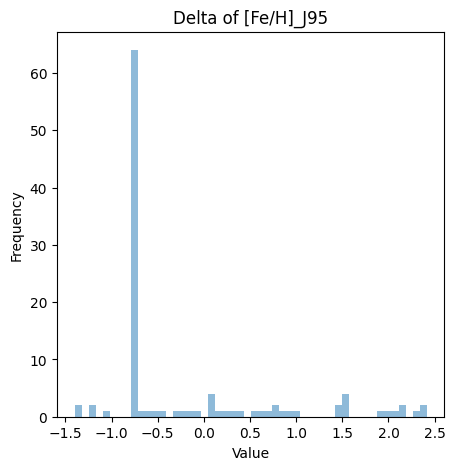

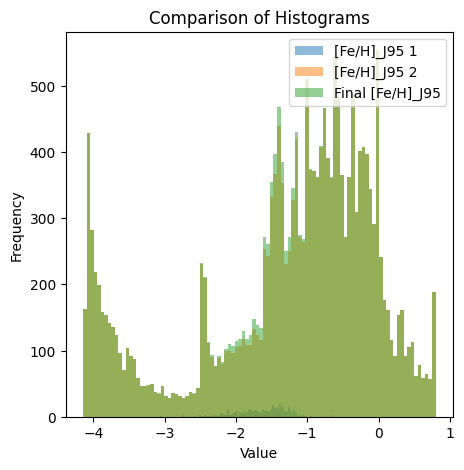

        Type             OGLE_id     teff_val     Period  abs_Gmag  radius_val
0       ACEP   OGLE-LMC-ACEP-019          NaN   0.909406  4.636482         NaN
2       ACEP   OGLE-LMC-ACEP-019          NaN   0.909406  4.636482         NaN
3       ACEP   OGLE-LMC-ACEP-074          NaN   1.533225  3.173356         NaN
4       ACEP   OGLE-LMC-ACEP-015          NaN   1.180879  3.802980         NaN
5       ACEP   OGLE-LMC-ACEP-062          NaN   1.059093  4.119264         NaN
...      ...                 ...          ...        ...       ...         ...
65755  T2CEP  OGLE-BLG-T2CEP-265  3644.750000  12.239628 -0.723831         NaN
65756  T2CEP  OGLE-BLG-T2CEP-125          NaN   2.292953  3.335377         NaN
65757  T2CEP  OGLE-BLG-T2CEP-227          NaN   1.639933  3.481937         NaN
65758  T2CEP  OGLE-BLG-T2CEP-201  3804.370117  11.319408 -1.013971         NaN
65759  T2CEP  OGLE-LMC-T2CEP-060          NaN   1.236598  5.763442         NaN

[62858 rows x 6 columns]
       index   Type       

In [11]:
df1 = meta1[['OGLE_id', '[Fe/H]_J95']]
df2 = meta2[["OGLE-ID", "[Fe/H]"]]

df1.columns = ['OGLE_id', '[Fe/H]_J95']
df2.columns = ['OGLE_id', '[Fe/H]_J95']

new_data = df1.merge(df2, on="OGLE_id", how="outer", suffixes=('_orig', '_new'))

new_data['delta_Teff'] = new_data["[Fe/H]_J95_orig"] - new_data["[Fe/H]_J95_new"]

new_data = update_values(new_data, feature="[Fe/H]_J95")

print('missing origin: ', new_data.drop_duplicates('OGLE_id')['[Fe/H]_J95_orig'].isna().sum())
print('missing new: ', new_data.drop_duplicates('OGLE_id')['[Fe/H]_J95_new'].isna().sum())
print('missing final: ', new_data.drop_duplicates('OGLE_id')['[Fe/H]_J95'].isna().sum())
print('range: ', new_data['[Fe/H]_J95'].min(), new_data['[Fe/H]_J95'].max()) 

basic_histogram(new_data.delta_Teff, title='Delta of [Fe/H]_J95')

compare_frequency(meta1.drop_duplicates('OGLE_id')['[Fe/H]_J95'], 
                    meta2.drop_duplicates('OGLE-ID')['[Fe/H]'], 
                    new_data.drop_duplicates('OGLE_id')['[Fe/H]_J95'], 
                    feature="[Fe/H]_J95", clean=False)

new_data = new_data[['OGLE_id', '[Fe/H]_J95']].dropna()
del meta1['[Fe/H]_J95']
print(meta1)
meta1.reset_index(inplace=True, drop=False)
meta1 = meta1.merge(new_data.drop_duplicates('OGLE_id'), on="OGLE_id", how="left", suffixes=('_orig', ''))
print(meta1)
meta1.set_index('index', inplace=True)
print('range new metadata: ', meta1['[Fe/H]_J95'].min(), meta1['[Fe/H]_J95'].max()) 
print('missing final: ', meta1.drop_duplicates('OGLE_id')['[Fe/H]_J95'].sum())


In [12]:
meta1.isnull().sum()


Type              0
OGLE_id           0
teff_val      19842
Period            0
abs_Gmag          0
radius_val    59453
[Fe/H]_J95    22375
dtype: int64

In [13]:
meta1.describe()

,teff_val,Period,abs_Gmag,radius_val,[Fe/H]_J95
count,43016.000000,62858.000000,62858.000000,3405.000000,40483.000000
mean,4762.127441,62.468948,2.144034,2.817720,-1.312028
std,1330.279297,123.862671,1.983594,1.559839,1.328705
min,3252.669922,0.060624,-3.580621,0.510000,-4.140200
25%,3709.000000,0.580292,0.797668,1.560000,-2.087800
50%,4546.000000,1.888099,2.068410,2.580000,-0.970800
75%,5307.000000,27.352522,3.440111,3.980000,-0.299350
max,9644.000000,977.469360,12.926695,17.320000,0.799100


In [14]:
meta1

,Type,OGLE_id,teff_val,Period,abs_Gmag,radius_val,[Fe/H]_J95
index,,,,,,,
0,ACEP,OGLE-LMC-ACEP-019,NaN,0.909406,4.636482,NaN,-4.0969
2,ACEP,OGLE-LMC-ACEP-019,NaN,0.909406,4.636482,NaN,-4.0969
3,ACEP,OGLE-LMC-ACEP-074,NaN,1.533225,3.173356,NaN,-1.9930
4,ACEP,OGLE-LMC-ACEP-015,NaN,1.180879,3.802980,NaN,-2.5218
5,ACEP,OGLE-LMC-ACEP-062,NaN,1.059093,4.119264,NaN,-3.6537
...,...,...,...,...,...,...,...
65755,T2CEP,OGLE-BLG-T2CEP-265,3644.750000,12.239628,-0.723831,NaN,NaN
65756,T2CEP,OGLE-BLG-T2CEP-125,NaN,2.292953,3.335377,NaN,NaN
65757,T2CEP,OGLE-BLG-T2CEP-227,NaN,1.639933,3.481937,NaN,NaN


# Merge Teff 

missing origin:  11315
missing new:  13701
missing final:  6071
range:  3067.7517 34970.637


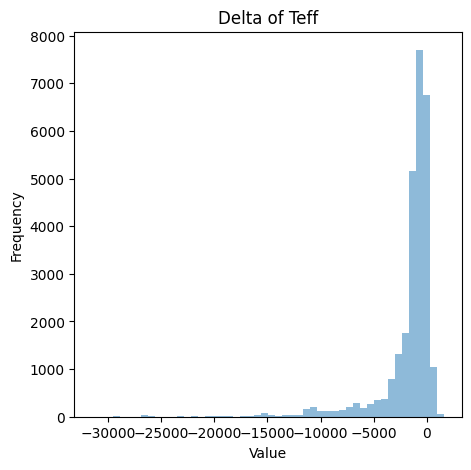

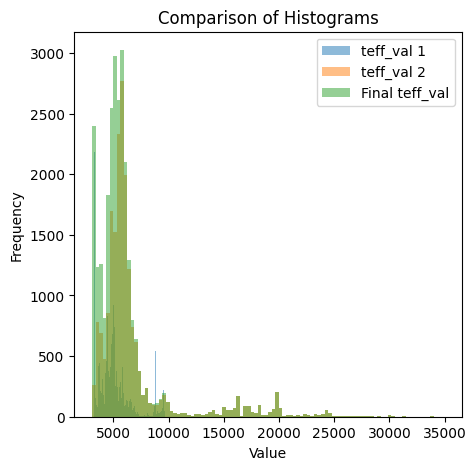

range new metadata:  3067.7517 34970.637
missing final:  4589


In [15]:

df1 = meta1[['OGLE_id', 'teff_val']]
df2 = meta2[["OGLE-ID", "Teff"]]

df1.columns = ['OGLE_id', 'teff_val']
df2.columns = ['OGLE_id', 'teff_val']

new_data = df1.merge(df2, on="OGLE_id", how="outer", suffixes=('_orig', '_new'))

new_data['delta_Teff'] = new_data["teff_val_orig"] - new_data["teff_val_new"]

new_data = update_values(new_data)

print('missing origin: ', new_data.drop_duplicates('OGLE_id').teff_val_orig.isna().sum())
print('missing new: ', new_data.drop_duplicates('OGLE_id').teff_val_new.isna().sum())
print('missing final: ', new_data.drop_duplicates('OGLE_id').teff_val.isna().sum())
print('range: ', new_data['teff_val'].min(), new_data['teff_val'].max()) 

basic_histogram(new_data.delta_Teff, title='Delta of Teff')

compare_frequency(meta1.drop_duplicates('OGLE_id').teff_val, 
                    meta2.drop_duplicates('OGLE-ID').Teff, 
                    new_data.drop_duplicates('OGLE_id').teff_val, 
                    feature="teff_val", clean=False)

new_data = new_data[['OGLE_id', 'teff_val']].dropna()
del meta1['teff_val']
meta1.reset_index(inplace=True, drop=False)
meta1 = meta1.merge(new_data.drop_duplicates('OGLE_id')[['OGLE_id', 'teff_val']], on="OGLE_id", how="left", suffixes=('_orig', ''))
print('range new metadata: ', meta1['teff_val'].min(), meta1['teff_val'].max()) 
print('missing final: ', meta1.drop_duplicates('OGLE_id').teff_val.isna().sum())
meta1.set_index('index', inplace=True)


In [16]:
meta1.describe()

,Period,abs_Gmag,radius_val,[Fe/H]_J95,teff_val
count,62858.000000,62858.000000,3405.000000,40483.000000,55533.000000
mean,62.468948,2.144034,2.817720,-1.312028,5819.788294
std,123.862671,1.983594,1.559839,1.328705,2988.050402
min,0.060624,-3.580621,0.510000,-4.140200,3067.751700
25%,0.580292,0.797668,1.560000,-2.087800,4419.000000
50%,1.888099,2.068410,2.580000,-0.970800,5347.753000
75%,27.352522,3.440111,3.980000,-0.299350,6122.488000
max,977.469360,12.926695,17.320000,0.799100,34970.637000


## Period

missing origin:  1634
missing new:  0
missing final:  0
range:  0.0606239659999999 977.46936


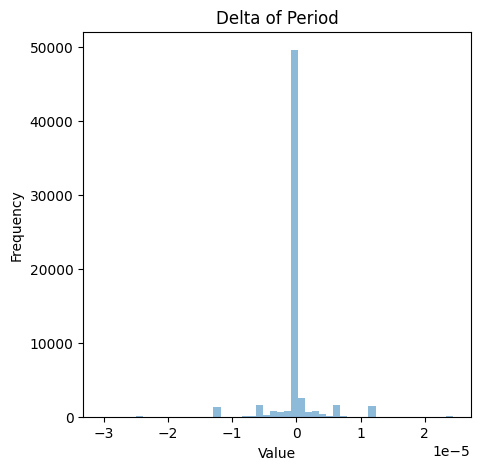

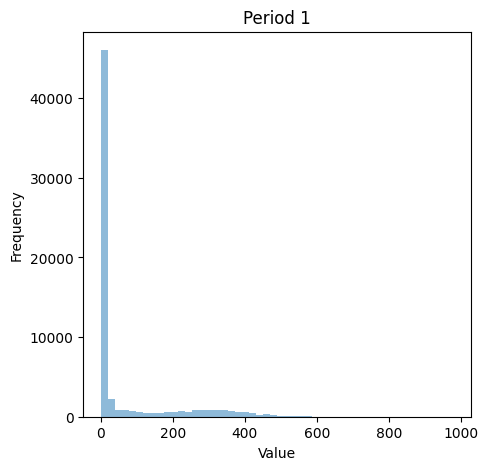

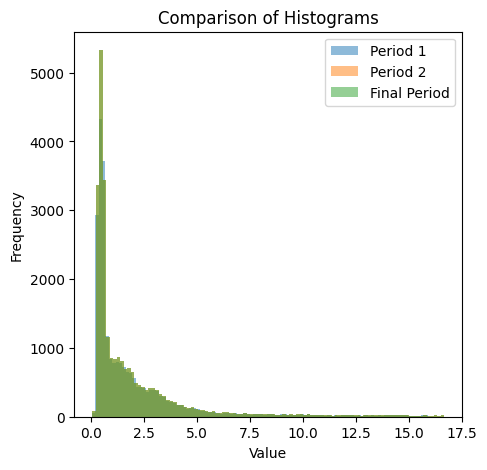

range new metadata:  0.0606239659999999 977.46936
missing final:  0


In [17]:
df1 = meta1[['OGLE_id', 'Period']]
df2 = meta2[["OGLE-ID", "Period"]]
df1.columns = ['OGLE_id', 'Period']
df2.columns = ['OGLE_id', 'Period']

new_data = df1.merge(df2, on="OGLE_id", how="outer", suffixes=('_orig', '_new'))

new_data['delta_Period'] = new_data["Period_orig"] - new_data["Period_new"]

new_data = update_values(new_data, feature="Period")

print('missing origin: ', new_data.drop_duplicates('OGLE_id').Period_orig.isna().sum())
print('missing new: ', new_data.drop_duplicates('OGLE_id').Period_new.isna().sum())
print('missing final: ', new_data.drop_duplicates('OGLE_id').Period.isna().sum())
print('range: ', new_data['Period'].min(), new_data['Period'].max()) 

basic_histogram(new_data.delta_Period, title='Delta of Period')

basic_histogram(meta1.Period, title='Period 1')

compare_frequency(meta1.drop_duplicates('OGLE_id').Period, meta2.drop_duplicates('OGLE-ID').Period, new_data.drop_duplicates('OGLE_id').Period, feature="Period")

new_data = new_data[['OGLE_id', 'Period']].dropna()
del meta1['Period']

meta1.reset_index(inplace=True, drop=False)
meta1 = meta1.merge(new_data.drop_duplicates('OGLE_id')[['OGLE_id', 'Period']], on="OGLE_id", how="left", suffixes=('_orig', ''))
print('range new metadata: ', meta1['Period'].min(), meta1['Period'].max()) 
meta1.set_index('index', inplace=True)

print('missing final: ', meta1.drop_duplicates('OGLE_id').Period.isna().sum())

In [18]:
meta1.describe()

,abs_Gmag,radius_val,[Fe/H]_J95,teff_val,Period
count,62858.000000,3405.000000,40483.000000,55533.000000,62858.000000
mean,2.144034,2.817720,-1.312028,5819.788294,62.468949
std,1.983594,1.559839,1.328705,2988.050402,123.862672
min,-3.580621,0.510000,-4.140200,3067.751700,0.060624
25%,0.797668,1.560000,-2.087800,4419.000000,0.580292
50%,2.068410,2.580000,-0.970800,5347.753000,1.888099
75%,3.440111,3.980000,-0.299350,6122.488000,27.352522
max,12.926695,17.320000,0.799100,34970.637000,977.469360


# Merge Abs Mag G

missing origin:  1634
missing new:  13701
missing final:  1481
range:  -6.9446 12.926694869995117


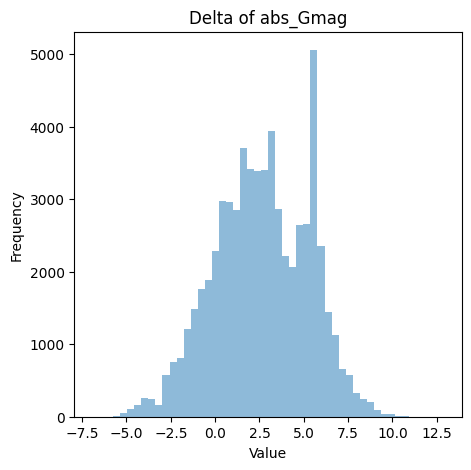

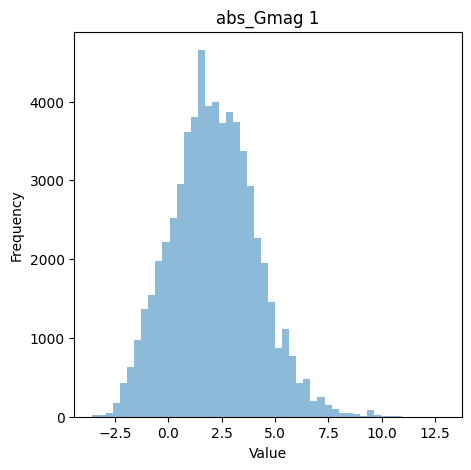

-3.5806208 12.926695
-6.9446 10.6707


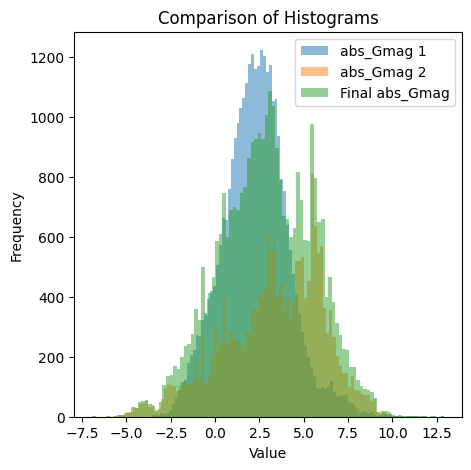

range new metadata:  -6.9446 12.926694869995117
missing final:  0


In [19]:
## 
df1 = meta1[['OGLE_id', 'abs_Gmag']]
df2 = meta2[["OGLE-ID", "GMAG_x"]]
df1.columns = ['OGLE_id', 'abs_Gmag']
df2.columns = ['OGLE_id', 'abs_Gmag']

#del new_data

new_data = df1.merge(df2, on="OGLE_id", how="outer", suffixes=('_orig', '_new'))

new_data['delta_abs_Gmag'] = new_data["abs_Gmag_orig"] - new_data["abs_Gmag_new"]

new_data = update_values(new_data, feature="abs_Gmag")

print('missing origin: ', new_data.drop_duplicates('OGLE_id').abs_Gmag_orig.isna().sum())
print('missing new: ', new_data.drop_duplicates('OGLE_id').abs_Gmag_new.isna().sum())
print('missing final: ', new_data.drop_duplicates('OGLE_id').abs_Gmag.isna().sum())
print('range: ', new_data['abs_Gmag'].min(), new_data['abs_Gmag'].max()) 

basic_histogram(new_data.abs_Gmag, title='Delta of abs_Gmag')

basic_histogram(meta1.abs_Gmag, title='abs_Gmag 1')

print(meta1.abs_Gmag.min(), meta1.abs_Gmag.max())
print(meta2.GMAG_x.min(), meta2.GMAG_x.max())



compare_frequency(meta1.drop_duplicates('OGLE_id').abs_Gmag, 
                 meta2.drop_duplicates('OGLE-ID').GMAG_x, 
                 new_data.drop_duplicates('OGLE_id').abs_Gmag, feature="abs_Gmag", clean=False)

new_data = new_data[['OGLE_id', 'abs_Gmag']].dropna()
del meta1['abs_Gmag']

meta1.reset_index(inplace=True, drop=False)
meta1 = meta1.merge(new_data.drop_duplicates('OGLE_id')[['OGLE_id', 'abs_Gmag']], on="OGLE_id", how="left", suffixes=('_orig', ''))
print('range new metadata: ', meta1['abs_Gmag'].min(), meta1['abs_Gmag'].max()) 
meta1.set_index('index', inplace=True)

print('missing final: ', meta1.drop_duplicates('OGLE_id').abs_Gmag.isna().sum())

In [20]:
meta1.describe()

,radius_val,[Fe/H]_J95,teff_val,Period,abs_Gmag
count,3405.000000,40483.000000,55533.000000,62858.000000,62858.000000
mean,2.817720,-1.312028,5819.788294,62.468949,2.644517
std,1.559839,1.328705,2988.050402,123.862672,2.651092
min,0.510000,-4.140200,3067.751700,0.060624,-6.944600
25%,1.560000,-2.087800,4419.000000,0.580292,0.759474
50%,2.580000,-0.970800,5347.753000,1.888099,2.667200
75%,3.980000,-0.299350,6122.488000,27.352522,4.851184
max,17.320000,0.799100,34970.637000,977.469360,12.926695


# radius


missing origin:  31415
missing new:  13701
missing final:  13477
range:  0.1792 758.462


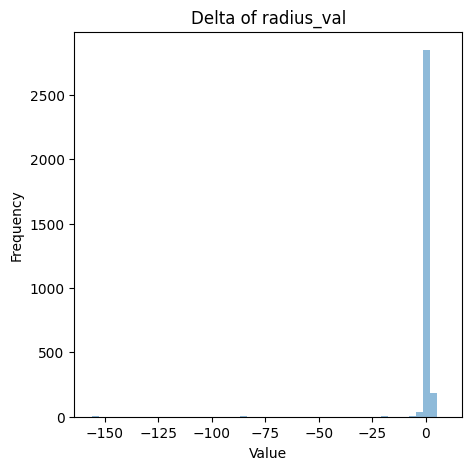

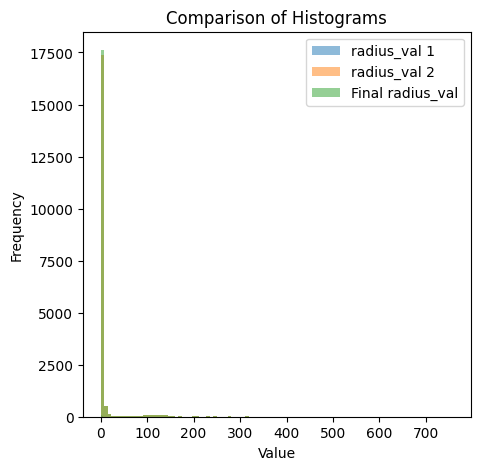

range new metadata:  0.1792 758.462
missing final:  11995


In [21]:
df1 = meta1[['OGLE_id', 'radius_val']]
df2 = meta2[["OGLE-ID", "Rad"]]
df1.columns = ['OGLE_id', 'radius_val']
df2.columns = ['OGLE_id', 'radius_val']


new_data = df1.merge(df2, on="OGLE_id", how="outer", suffixes=('_orig', '_new'))

new_data['delta_radius_val'] = new_data["radius_val_orig"] - new_data["radius_val_new"]

new_data = update_values(new_data, feature="radius_val")

print('missing origin: ', new_data.drop_duplicates('OGLE_id')['radius_val_orig'].isna().sum())
print('missing new: ', new_data.drop_duplicates('OGLE_id')['radius_val_new'].isna().sum())
print('missing final: ', new_data.drop_duplicates('OGLE_id')['radius_val'].isna().sum())
print('range: ', new_data['radius_val'].min(), new_data['radius_val'].max()) 

basic_histogram(new_data.delta_radius_val, title='Delta of radius_val')

compare_frequency(meta1.drop_duplicates('OGLE_id')['radius_val'], 
                    meta2.drop_duplicates('OGLE-ID')['Rad'], 
                    new_data.drop_duplicates('OGLE_id')['radius_val'], 
                    feature="radius_val", clean=False)

new_data = new_data[['OGLE_id', 'radius_val']].dropna()
del meta1['radius_val']

meta1.reset_index(inplace=True, drop=False)
meta1 = meta1.merge(new_data.drop_duplicates('OGLE_id'), on="OGLE_id", how="left", suffixes=('_orig', ''))
print('range new metadata: ', meta1['radius_val'].min(), meta1['radius_val'].max()) 
meta1.set_index('index', inplace=True)

print('missing final: ', meta1.drop_duplicates('OGLE_id')['radius_val'].isna().sum())


In [22]:
meta1.sort_values('radius_val', ascending=False).head(10)

,Type,OGLE_id,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val
index,,,,,,,
47983,LPV,OGLE-BLG-LPV-181094,0.4740,3451.6543,356.2,-6.0022,758.4620
50254,LPV,OGLE-BLG-LPV-127562,0.6959,3286.1375,465.1,-4.7767,664.6299
45256,LPV,OGLE-BLG-LPV-127562,0.6959,3286.1375,465.1,-4.7767,664.6299
43643,LPV,OGLE-BLG-LPV-157191,0.6504,3251.3984,388.6,-4.3649,610.9427
48357,LPV,OGLE-BLG-LPV-157191,0.6504,3251.3984,388.6,-4.3649,610.9427
48091,LPV,OGLE-BLG-LPV-176493,0.5064,3585.0667,316.7,-5.6746,569.6616
49734,LPV,OGLE-BLG-LPV-107329,0.5615,3323.0825,403.5,-4.7173,568.6832
41337,LPV,OGLE-BLG-LPV-141260,0.7937,3390.5217,406.8,-4.9795,558.5021
43258,LPV,OGLE-BLG-LPV-141260,0.7937,3390.5217,406.8,-4.9795,558.5021


In [23]:
meta1.describe()

,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val
count,40483.000000,55533.000000,62858.000000,62858.000000,40393.000000
mean,-1.312028,5819.788294,62.468949,2.644517,13.187802
std,1.328705,2988.050402,123.862672,2.651092,45.976521
min,-4.140200,3067.751700,0.060624,-6.944600,0.179200
25%,-2.087800,4419.000000,0.580292,0.759474,0.772100
50%,-0.970800,5347.753000,1.888099,2.667200,1.470200
75%,-0.299350,6122.488000,27.352522,4.851184,3.244400
max,0.799100,34970.637000,977.469360,12.926695,758.462000


In [24]:
meta1.isnull().sum()

Type              0
OGLE_id           0
[Fe/H]_J95    22375
teff_val       7325
Period            0
abs_Gmag          0
radius_val    22465
dtype: int64

In [25]:
meta1.describe()

,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val
count,40483.000000,55533.000000,62858.000000,62858.000000,40393.000000
mean,-1.312028,5819.788294,62.468949,2.644517,13.187802
std,1.328705,2988.050402,123.862672,2.651092,45.976521
min,-4.140200,3067.751700,0.060624,-6.944600,0.179200
25%,-2.087800,4419.000000,0.580292,0.759474,0.772100
50%,-0.970800,5347.753000,1.888099,2.667200,1.470200
75%,-0.299350,6122.488000,27.352522,4.851184,3.244400
max,0.799100,34970.637000,977.469360,12.926695,758.462000


# Log G

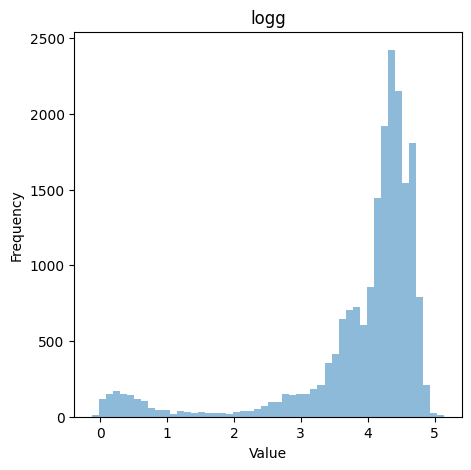

,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val,logg
count,40483.000000,55533.000000,62858.000000,62858.000000,40393.000000,40074.000000
mean,-1.312028,5819.788294,62.468949,2.644517,13.187802,3.805396
std,1.328705,2988.050402,123.862672,2.651092,45.976521,1.122691
min,-4.140200,3067.751700,0.060624,-6.944600,0.179200,-0.120700
25%,-2.087800,4419.000000,0.580292,0.759474,0.772100,3.582425
50%,-0.970800,5347.753000,1.888099,2.667200,1.470200,4.220500
75%,-0.299350,6122.488000,27.352522,4.851184,3.244400,4.532200
max,0.799100,34970.637000,977.469360,12.926695,758.462000,5.145000


In [26]:
df2 = meta2[["OGLE-ID", "logg"]]
df2.columns = ["OGLE_id", "logg"]

basic_histogram(df2.logg, title='logg')

df2 = df2[['OGLE_id', 'logg']].dropna()

meta1.reset_index(inplace=True, drop=False)
meta1 = meta1.merge(df2.drop_duplicates('OGLE_id'), on="OGLE_id", how="left", suffixes=('_orig', ''))
meta1.set_index('index', inplace=True)


meta1.describe()

# select curves from df indexes

In [27]:
lcs = lcs[meta1.index.values, :, :]
meta1 = meta1.reset_index()
del meta1['index']

In [29]:
meta1

,Type,OGLE_id,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val,logg
0,ACEP,OGLE-LMC-ACEP-019,-4.0969,6103.2220,0.909406,5.169300,0.7522,4.5263
1,ACEP,OGLE-LMC-ACEP-019,-4.0969,6103.2220,0.909406,5.169300,0.7522,4.5263
2,ACEP,OGLE-LMC-ACEP-074,-1.9930,5953.8896,1.533225,5.378700,0.7011,4.5801
3,ACEP,OGLE-LMC-ACEP-015,-2.5218,5983.3730,1.180879,5.376900,0.7006,4.5769
4,ACEP,OGLE-LMC-ACEP-062,-3.6537,5845.3520,1.059093,5.639900,0.6555,4.6286
...,...,...,...,...,...,...,...,...
62853,T2CEP,OGLE-BLG-T2CEP-265,NaN,3644.7500,12.239628,-0.723831,NaN,NaN
62854,T2CEP,OGLE-BLG-T2CEP-125,NaN,NaN,2.292953,3.335377,NaN,NaN
62855,T2CEP,OGLE-BLG-T2CEP-227,NaN,NaN,1.639933,3.481937,NaN,NaN
62856,T2CEP,OGLE-BLG-T2CEP-201,-0.2443,6367.6080,11.319408,-1.842000,17.6560,2.5101


In [30]:
lcs

array([[[1.1097110e-03, 1.7700790e+01, 1.8999999e-02],
        [3.2942146e-03, 1.7631012e+01, 2.3000000e-02],
        [1.5009778e-02, 1.7589676e+01, 2.1000000e-02],
        ...,
        [1.9796976e+00, 1.7680084e+01, 2.1000000e-02],
        [1.9859014e+00, 1.7645636e+01, 1.8999999e-02],
        [1.9958012e+00, 1.7607756e+01, 2.1000000e-02]],

       [[5.1106387e-03, 1.7273479e+01, 2.1000000e-02],
        [5.5310233e-03, 1.7175858e+01, 1.8999999e-02],
        [8.6920988e-03, 1.7164326e+01, 1.4000000e-02],
        ...,
        [1.9941753e+00, 1.7124809e+01, 1.4000000e-02],
        [1.9957510e+00, 1.7153591e+01, 1.7999999e-02],
        [1.9977432e+00, 1.7123062e+01, 1.3000000e-02]],

       [[7.2065345e-03, 1.7040936e+01, 1.3000000e-02],
        [7.3592844e-03, 1.7052214e+01, 1.5000000e-02],
        [8.1960829e-03, 1.7009415e+01, 1.4000000e-02],
        ...,
        [1.9906991e+00, 1.7050720e+01, 1.3000000e-02],
        [1.9916787e+00, 1.7030548e+01, 1.2000000e-02],
        [1.9987348e+00

In [31]:

#save_data(meta1, lcs, data, data_path = 'data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_6PP.npy.gz')

# Apply log transformation

In [32]:
meta1.loc[:, 'radius_val'] = np.log10(meta1['radius_val'].values)
meta1.loc[:, 'teff_val'] = np.log10(meta1['teff_val'].values)
meta1.loc[:, 'Period'] = np.log10(meta1['Period'].values)
meta1

,Type,OGLE_id,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val,logg
0,ACEP,OGLE-LMC-ACEP-019,-4.0969,3.785559,-0.041242,5.169300,-0.123667,4.5263
1,ACEP,OGLE-LMC-ACEP-019,-4.0969,3.785559,-0.041242,5.169300,-0.123667,4.5263
2,ACEP,OGLE-LMC-ACEP-074,-1.9930,3.774801,0.185606,5.378700,-0.154220,4.5801
3,ACEP,OGLE-LMC-ACEP-015,-2.5218,3.776946,0.072205,5.376900,-0.154530,4.5769
4,ACEP,OGLE-LMC-ACEP-062,-3.6537,3.766811,0.024934,5.639900,-0.183427,4.6286
...,...,...,...,...,...,...,...,...
62853,T2CEP,OGLE-BLG-T2CEP-265,NaN,3.561668,1.087768,-0.723831,NaN,NaN
62854,T2CEP,OGLE-BLG-T2CEP-125,NaN,NaN,0.360395,3.335377,NaN,NaN
62855,T2CEP,OGLE-BLG-T2CEP-227,NaN,NaN,0.214826,3.481937,NaN,NaN
62856,T2CEP,OGLE-BLG-T2CEP-201,-0.2443,3.803976,1.053824,-1.842000,1.246892,2.5101


In [33]:

#save_data(meta1, lcs, data, data_path = 'data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_LOG_6PP.npy.gz')

# Apply imputation

In [34]:
#!pip install scikit-learn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler


In [35]:
# Step 1: Remove 'column_id' and keep it in a separate DataFrame
df_column_id = meta1[['OGLE_id']]
df_data = meta1.drop(['OGLE_id'], axis=1)
df_column_class = df_data[['Type']]
df_data = df_data.drop(['Type'], axis=1)


original_index = df_data.index
original_columns = df_data.columns

# Initialize the Scaler
scaler = MinMaxScaler()

# Fit and transform the data to scale
df_scaled = pd.DataFrame(scaler.fit_transform(df_data[original_columns]), columns=original_columns)


# Step 3: Initialize KNNImputer and perform imputation on scaled data
knn_imputer = KNNImputer(n_neighbors=5)
df_scaled_imputed = knn_imputer.fit_transform(df_scaled)

# Step 4: Scale the rows back to their original range
df_imputed = pd.DataFrame(scaler.inverse_transform(df_scaled_imputed), index=original_index, columns=original_columns)


print("Imputed DataFrame with 'column_id':")


Imputed DataFrame with 'column_id':


In [36]:
df_imputed

,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val,logg
0,-4.09690,3.785559,-0.041242,5.169300,-0.123667,4.52630
1,-4.09690,3.785559,-0.041242,5.169300,-0.123667,4.52630
2,-1.99300,3.774801,0.185606,5.378700,-0.154220,4.58010
3,-2.52180,3.776946,0.072205,5.376900,-0.154530,4.57690
4,-3.65370,3.766811,0.024934,5.639900,-0.183427,4.62860
...,...,...,...,...,...,...
62853,-0.53228,3.561668,1.087768,-0.723831,1.329061,1.76342
62854,-1.08216,3.786904,0.360395,3.335377,0.219420,3.94260
62855,-2.14106,3.787185,0.214826,3.481937,0.193797,4.07534
62856,-0.24430,3.803976,1.053824,-1.842000,1.246892,2.51010


In [37]:
df_imputed.insert(0, 'OGLE_id', df_column_id)
df_imputed.insert(0, 'Type', df_column_class)

df_imputed

,Type,OGLE_id,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val,logg
0,ACEP,OGLE-LMC-ACEP-019,-4.09690,3.785559,-0.041242,5.169300,-0.123667,4.52630
1,ACEP,OGLE-LMC-ACEP-019,-4.09690,3.785559,-0.041242,5.169300,-0.123667,4.52630
2,ACEP,OGLE-LMC-ACEP-074,-1.99300,3.774801,0.185606,5.378700,-0.154220,4.58010
3,ACEP,OGLE-LMC-ACEP-015,-2.52180,3.776946,0.072205,5.376900,-0.154530,4.57690
4,ACEP,OGLE-LMC-ACEP-062,-3.65370,3.766811,0.024934,5.639900,-0.183427,4.62860
...,...,...,...,...,...,...,...,...
62853,T2CEP,OGLE-BLG-T2CEP-265,-0.53228,3.561668,1.087768,-0.723831,1.329061,1.76342
62854,T2CEP,OGLE-BLG-T2CEP-125,-1.08216,3.786904,0.360395,3.335377,0.219420,3.94260
62855,T2CEP,OGLE-BLG-T2CEP-227,-2.14106,3.787185,0.214826,3.481937,0.193797,4.07534
62856,T2CEP,OGLE-BLG-T2CEP-201,-0.24430,3.803976,1.053824,-1.842000,1.246892,2.51010


In [38]:
#save_data(df_imputed, lcs, data, data_path = 'data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_LOG_IMPUTED_6PP.npy.gz')

In [39]:
df_imputed.loc[:, 'radius_val'] = 10 ** df_imputed['radius_val'].values
df_imputed.loc[:, 'teff_val'] = 10 ** df_imputed['teff_val'].values
df_imputed.loc[:, 'Period'] = 10 ** df_imputed['Period'].values
df_imputed

,Type,OGLE_id,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val,logg
0,ACEP,OGLE-LMC-ACEP-019,-4.09690,6103.222000,0.909406,5.169300,0.752200,4.52630
1,ACEP,OGLE-LMC-ACEP-019,-4.09690,6103.222000,0.909406,5.169300,0.752200,4.52630
2,ACEP,OGLE-LMC-ACEP-074,-1.99300,5953.889600,1.533225,5.378700,0.701100,4.58010
3,ACEP,OGLE-LMC-ACEP-015,-2.52180,5983.373000,1.180879,5.376900,0.700600,4.57690
4,ACEP,OGLE-LMC-ACEP-062,-3.65370,5845.352000,1.059093,5.639900,0.655500,4.62860
...,...,...,...,...,...,...,...,...
62853,T2CEP,OGLE-BLG-T2CEP-265,-0.53228,3644.750000,12.239628,-0.723831,21.333434,1.76342
62854,T2CEP,OGLE-BLG-T2CEP-125,-1.08216,6122.144209,2.292953,3.335377,1.657372,3.94260
62855,T2CEP,OGLE-BLG-T2CEP-227,-2.14106,6126.113596,1.639933,3.481937,1.562418,4.07534
62856,T2CEP,OGLE-BLG-T2CEP-201,-0.24430,6367.608000,11.319408,-1.842000,17.656000,2.51010


In [40]:
save_data(df_imputed, lcs, data, data_path = 'data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_IMPUTED_6PP.npy.gz')

Saving to:
 data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600_GAIA3_IMPUTED_6PP.npy.gz
Data saved successfully.


In [41]:
df_imputed

,Type,OGLE_id,[Fe/H]_J95,teff_val,Period,abs_Gmag,radius_val,logg
0,ACEP,OGLE-LMC-ACEP-019,-4.09690,6103.222000,0.909406,5.169300,0.752200,4.52630
1,ACEP,OGLE-LMC-ACEP-019,-4.09690,6103.222000,0.909406,5.169300,0.752200,4.52630
2,ACEP,OGLE-LMC-ACEP-074,-1.99300,5953.889600,1.533225,5.378700,0.701100,4.58010
3,ACEP,OGLE-LMC-ACEP-015,-2.52180,5983.373000,1.180879,5.376900,0.700600,4.57690
4,ACEP,OGLE-LMC-ACEP-062,-3.65370,5845.352000,1.059093,5.639900,0.655500,4.62860
...,...,...,...,...,...,...,...,...
62853,T2CEP,OGLE-BLG-T2CEP-265,-0.53228,3644.750000,12.239628,-0.723831,21.333434,1.76342
62854,T2CEP,OGLE-BLG-T2CEP-125,-1.08216,6122.144209,2.292953,3.335377,1.657372,3.94260
62855,T2CEP,OGLE-BLG-T2CEP-227,-2.14106,6126.113596,1.639933,3.481937,1.562418,4.07534
62856,T2CEP,OGLE-BLG-T2CEP-201,-0.24430,6367.608000,11.319408,-1.842000,17.656000,2.51010


In [71]:
meta2 = load_new_validated_pp()
meta2.columns

Index(['OGLE-ID', 'Dec', 'Period', 'RA', 'SNR', 'Type', 'subType', 'V', 'V_I',
       'I', 'Gaia_DR3Name', 'RAdeg', 'DEdeg', 'e_RAdeg', 'e_DEdeg', 'Plx',
       'e_Plx', 'RUWE', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag',
       'e_RPmag', 'Teff', 'b_Teff_x', 'B_Teff_xa', 'logg', 'b_logg_x',
       'B_logg_xa', '[Fe/H]', 'b_[Fe/H]_x', 'B_[Fe/H]_xa', 'Dist', 'b_Dist_x',
       'B_Dist_xa', 'GMAG_x', 'b_GMAG_x', 'B_GMAG_xa', 'Rad', 'b_Rad_x',
       'B_Rad_xa', 'Rad-Flame', 'b_Rad-Flame_x', 'B_Rad-Flame_xa', 'Lum-Flame',
       'b_Lum-Flame_x', 'B_Lum-Flame_xa', 'Mass-Flame', 'b_Mass-Flame_x',
       'B_Mass-Flame_xa', 'Age-Flame', 'b_Age-Flame_x', 'B_Age-Flame_xa'],
      dtype='object')

In [106]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yaml
from typing import List, Optional, Any, Dict

with open('src/paths.yaml', 'r') as file:
    YAML_FILE: Dict[str, Any] = yaml.safe_load(file)

PATHS: Dict[str, str] = YAML_FILE['paths']
PATH_PRIOS: str = PATHS['PATH_PRIOS']
PATH_MODELS: str = PATHS['PATH_MODELS']
PATH_FIGURES: str = PATHS['PATH_FIGURES']

def plot_error(meta, column='Teff', lower_column='b_Teff_x', upper_column='B_Teff_xa', type='RRLYR'):

    data = meta[meta['Type'] == type]
    data = data[[column, lower_column, upper_column]]
    df = pd.DataFrame(data)
    df = df.sort_values(column)

    # Create the plot with specified figure size
    fig, ax = plt.subplots(figsize=(13, 6))
    
    # Extract arrays for the respective columns
    Teff = df[column].values
    b_Teff_x = df[lower_column].values
    B_Teff_xa = df[upper_column].values
    indices = np.arange(len(df))

    # Plot vertical lines representing the limit bars
    ax.vlines(indices, b_Teff_x, B_Teff_xa, color='red', linestyle='--', label='Limit Bar')
    
    # Adding labels and title
    ax.set_xlabel('Index')
    ax.set_ylabel(column)
    ax.set_title(f'{column} with Limit Bars for Type {type}')
    ax.legend()

    # Show the plot
    #plt.show()
    column = str(column).replace('/', '')
    plt.savefig(PATH_FIGURES+'_'+str(type)+'_'+str(column)+'.pdf')



In [107]:
meta2['Type'].unique()

array(['ECL', 'CEP', 'LPV', 'RRLYR', 'ELL', 'T2CEP', 'DSCT', 'ACEP'],
      dtype=object)

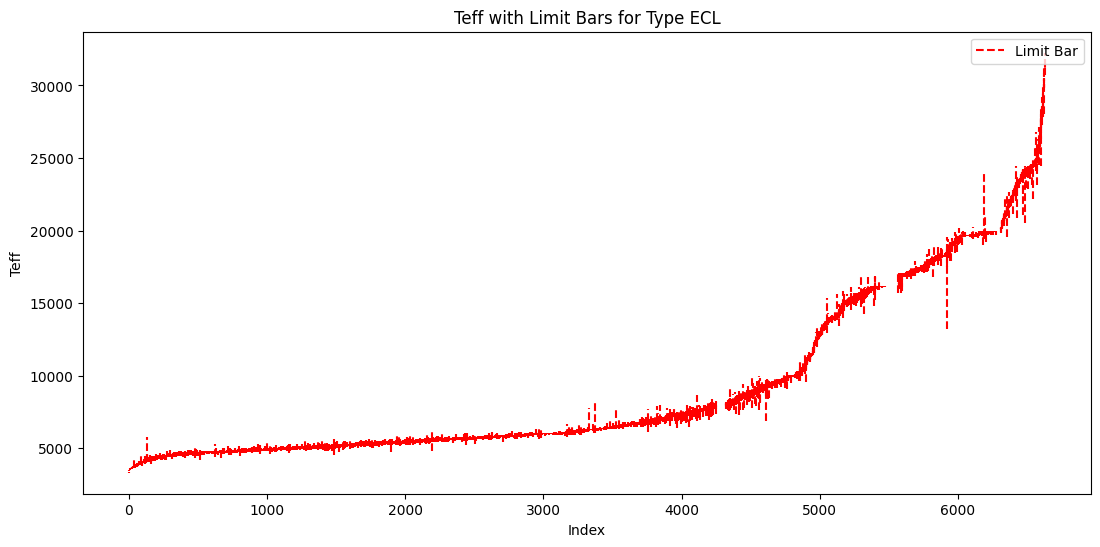

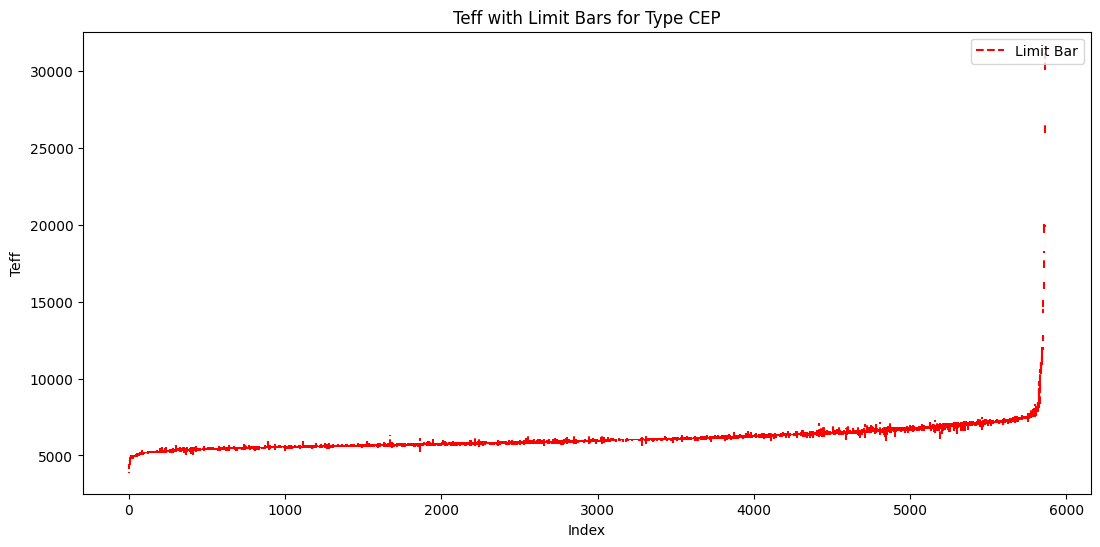

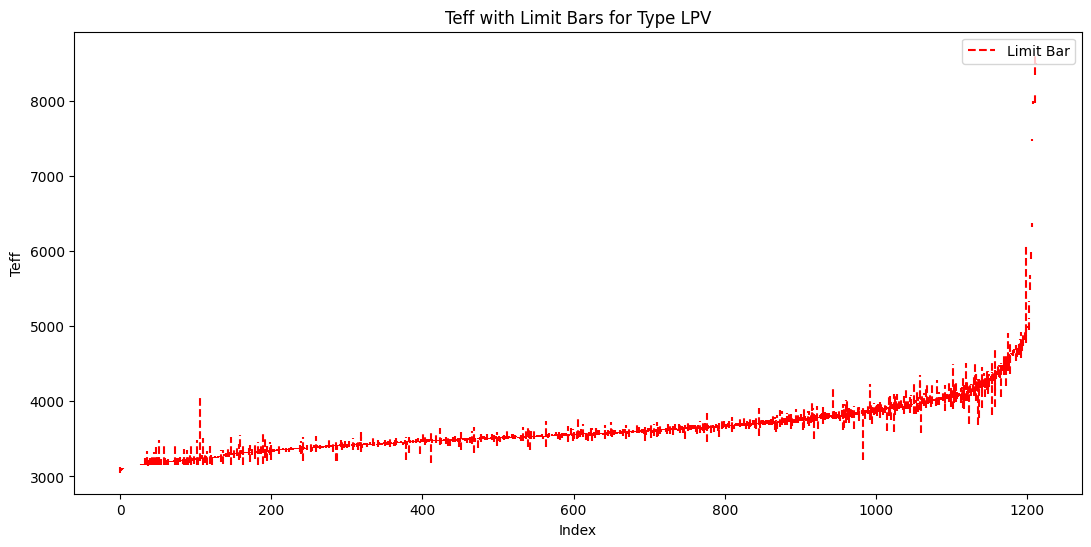

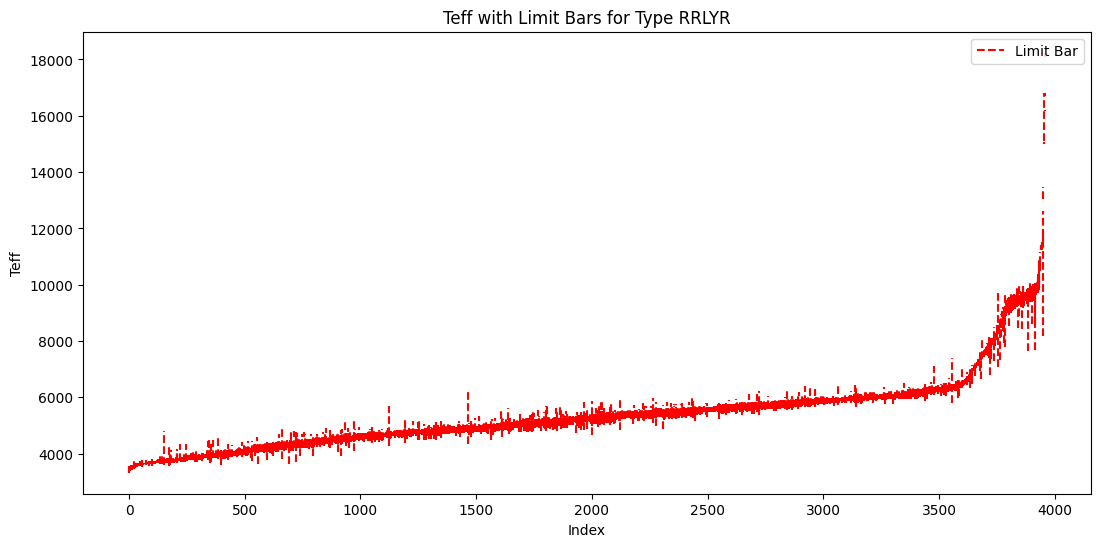

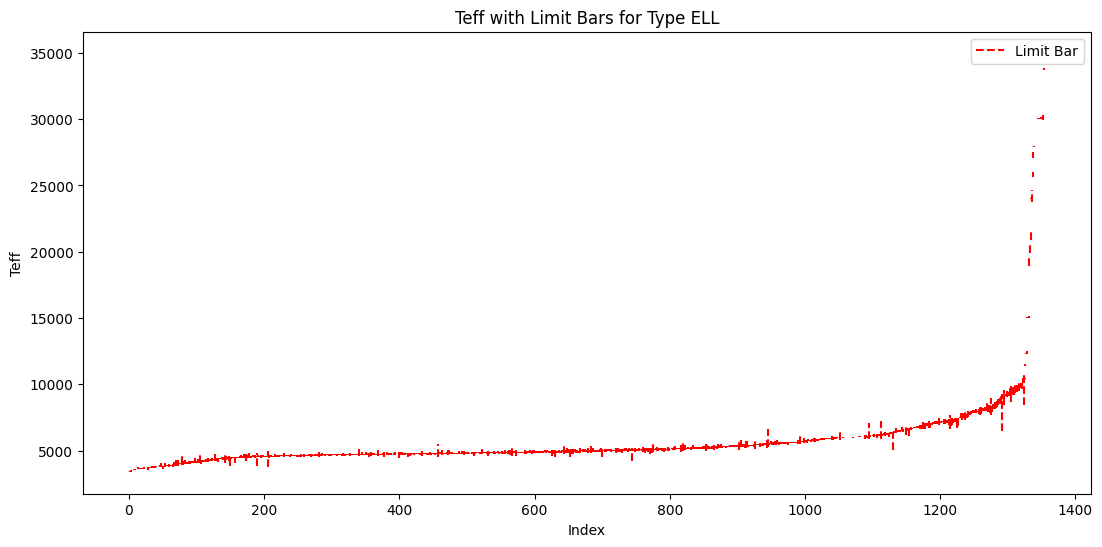

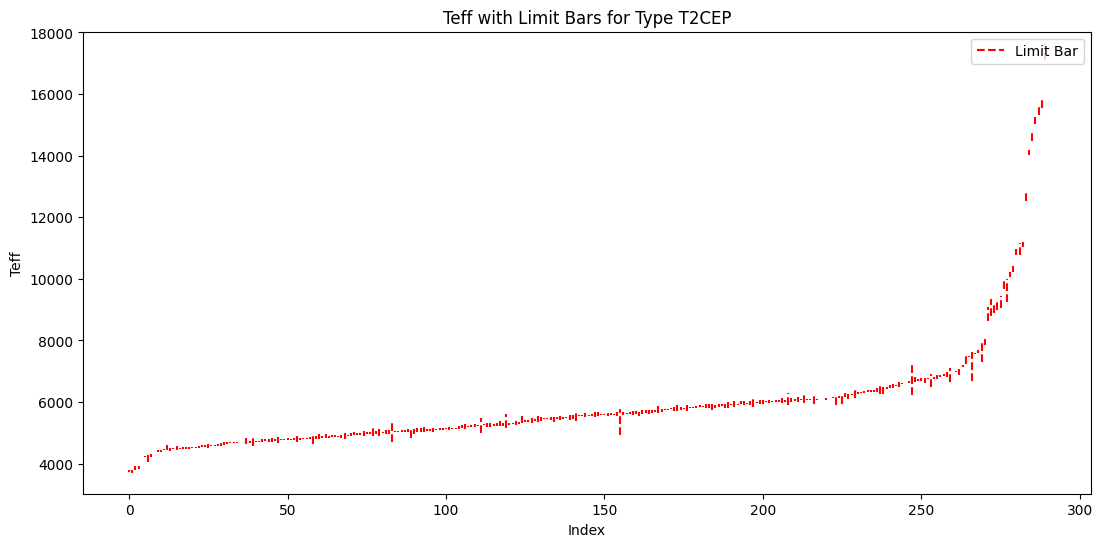

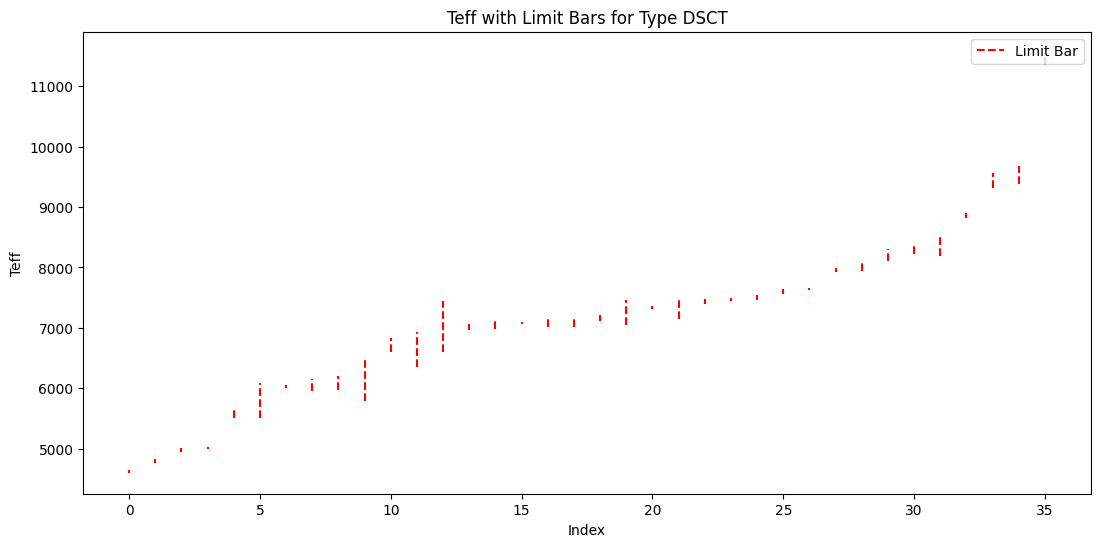

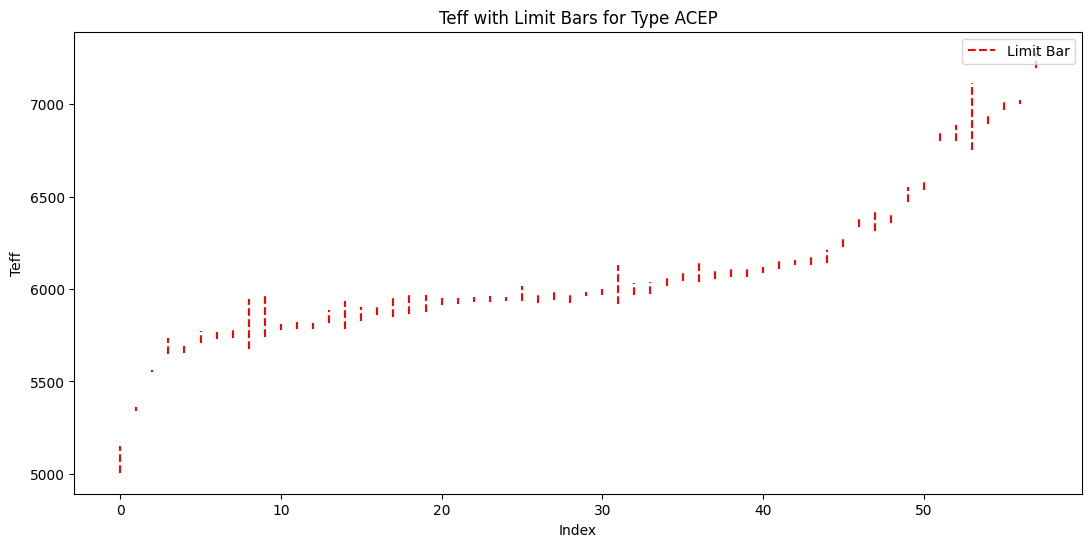

In [108]:
for classes in ['ECL', 'CEP', 'LPV', 'RRLYR', 'ELL', 'T2CEP', 'DSCT', 'ACEP']: 
    plot_error(meta2, column='Teff', lower_column='b_Teff_x', upper_column='B_Teff_xa', type=classes)

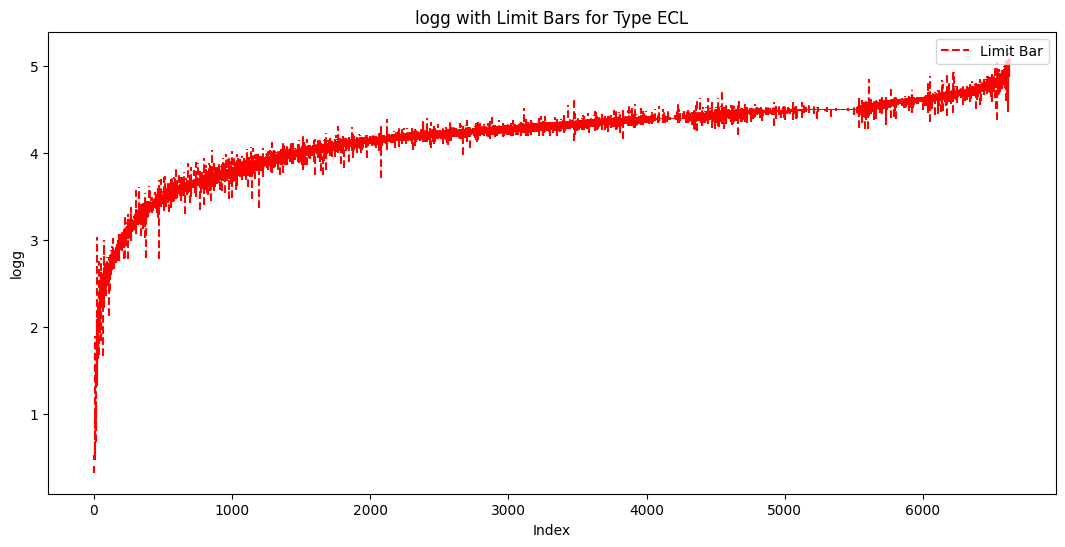

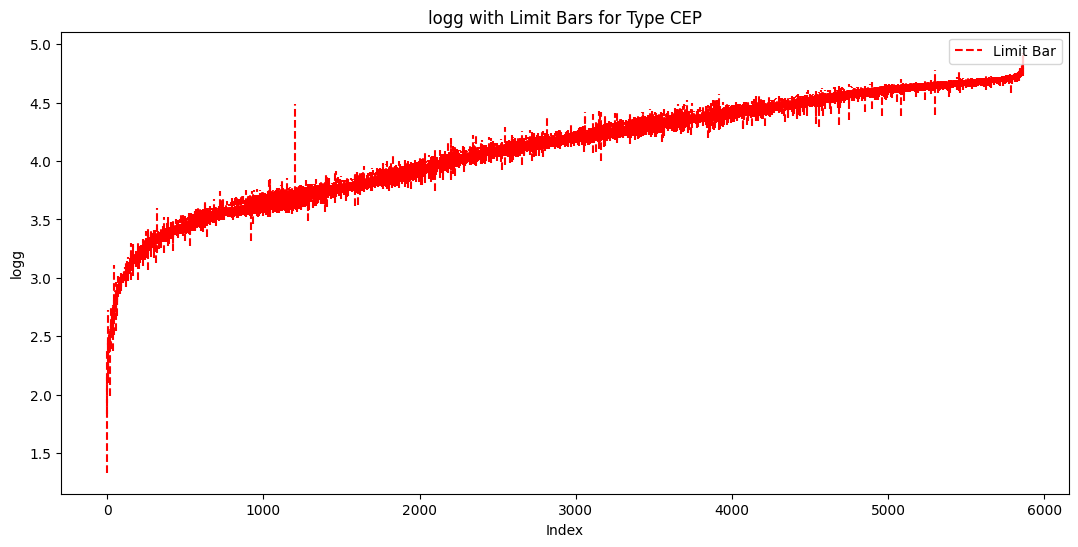

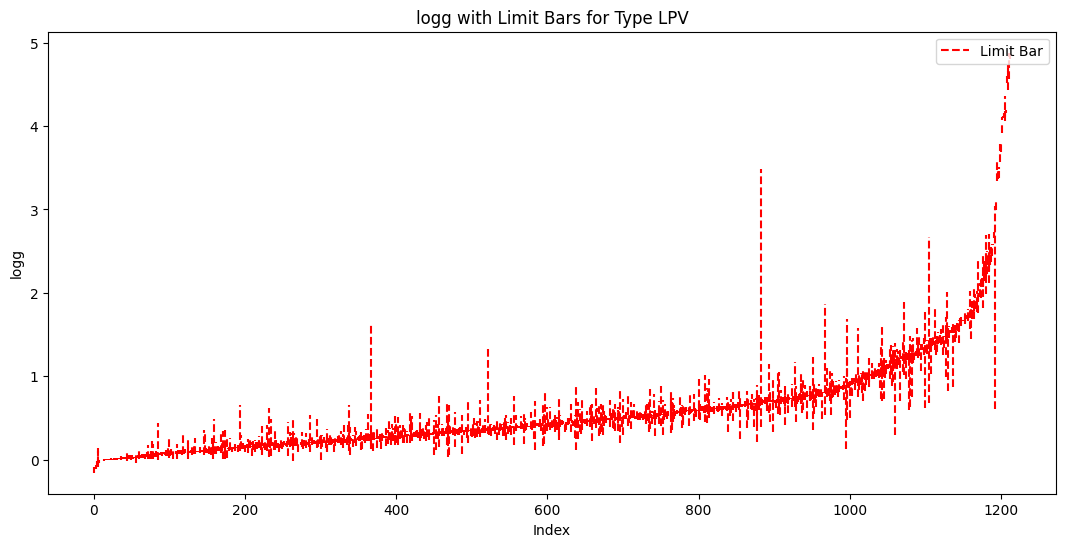

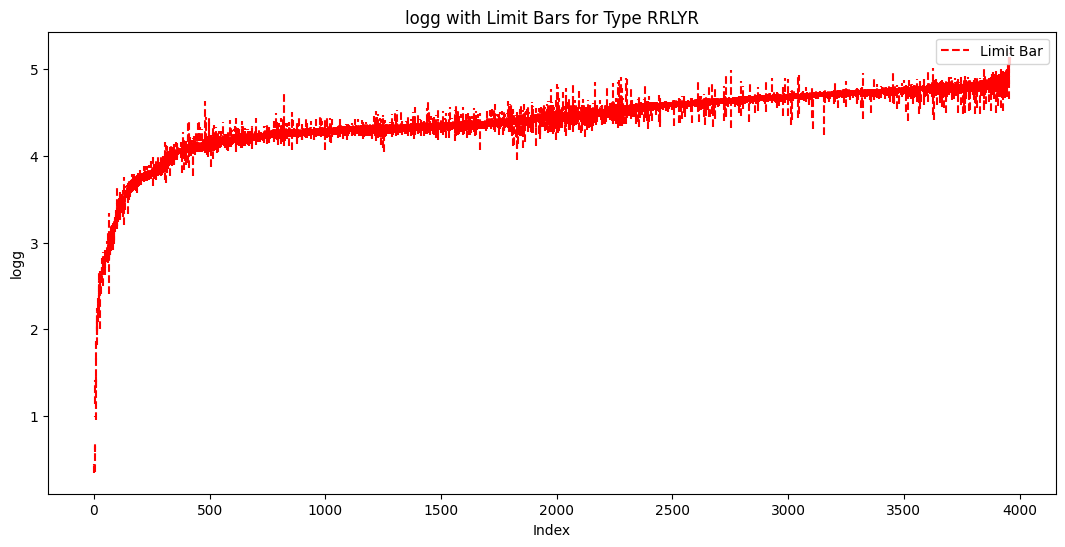

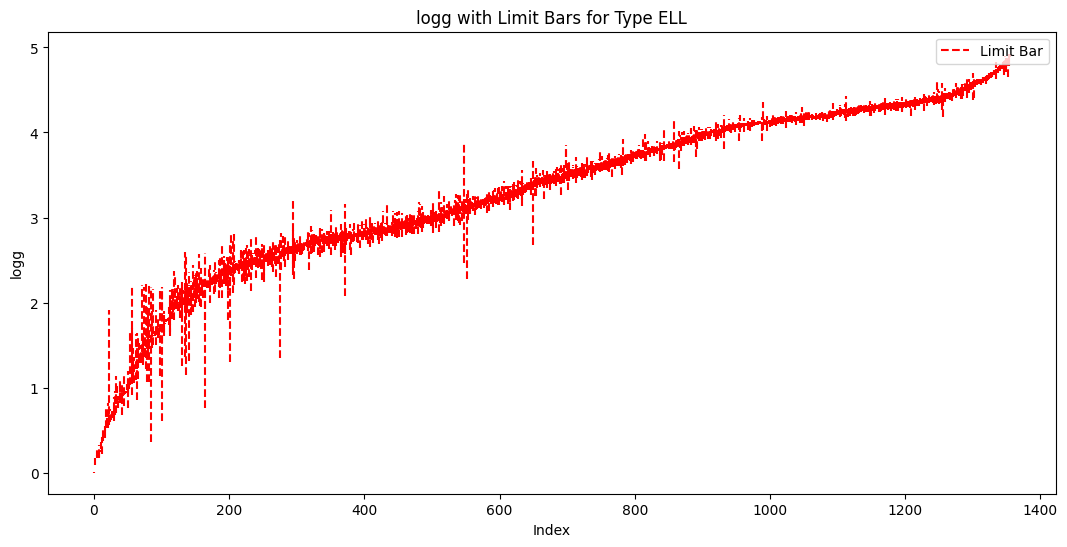

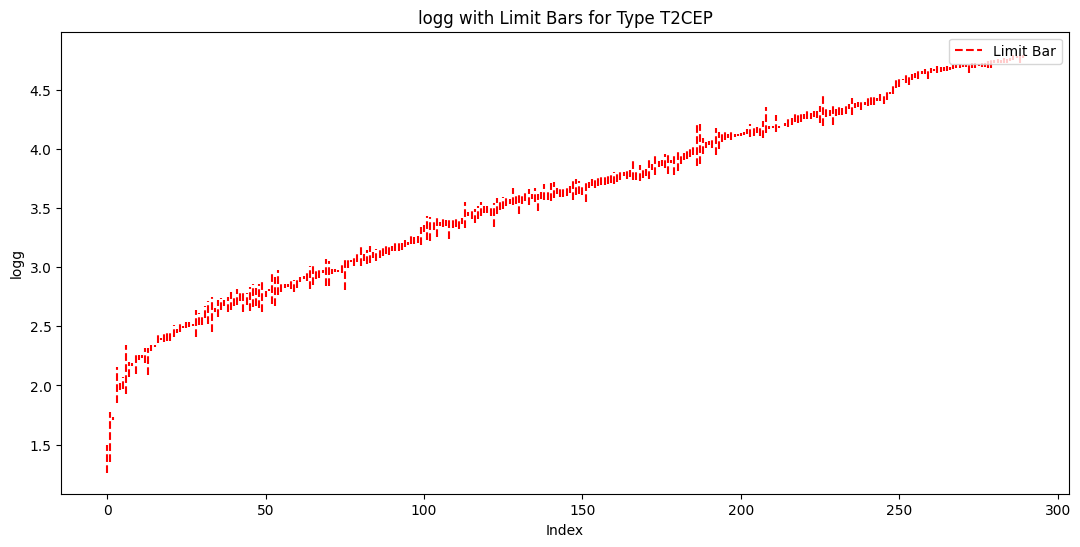

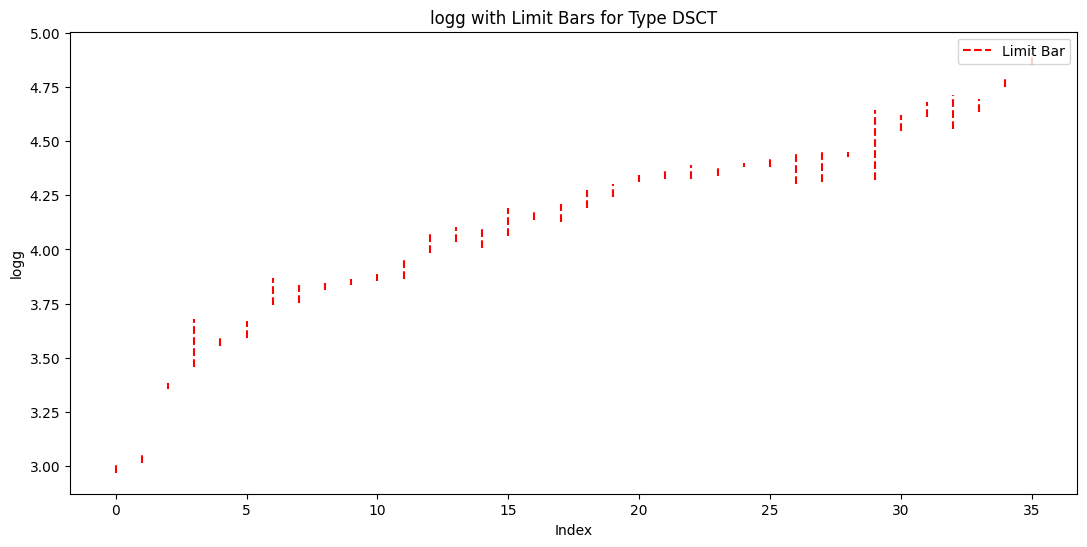

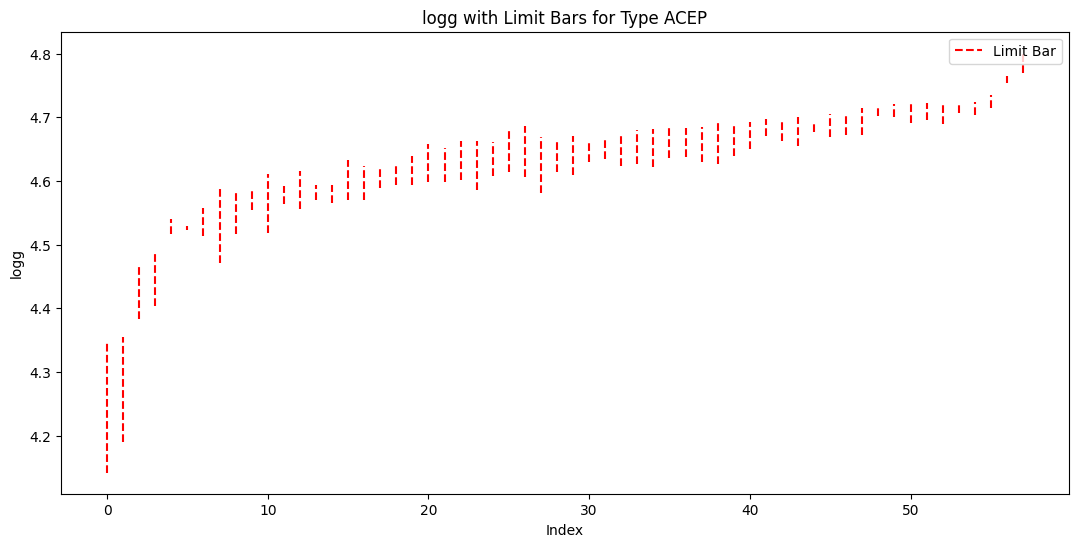

In [109]:
for classes in ['ECL', 'CEP', 'LPV', 'RRLYR', 'ELL', 'T2CEP', 'DSCT', 'ACEP']: 
    plot_error(meta2, column='logg', lower_column='b_logg_x', upper_column='B_logg_xa', type=classes)

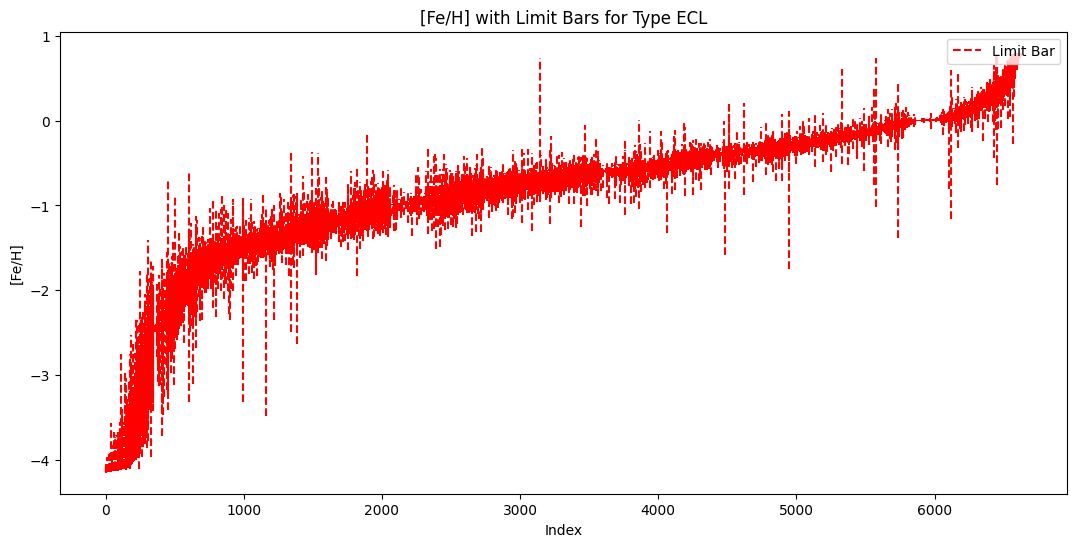

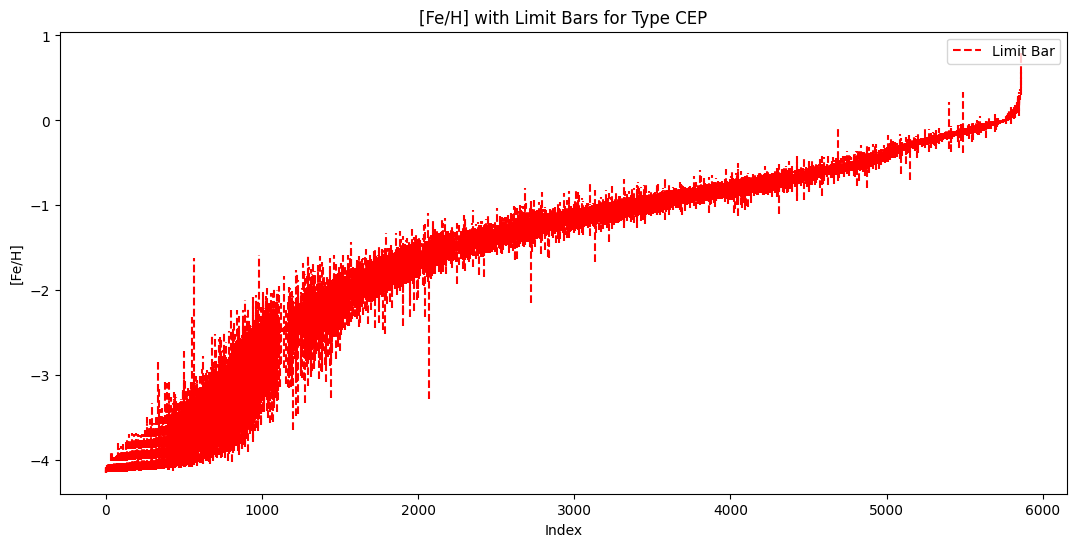

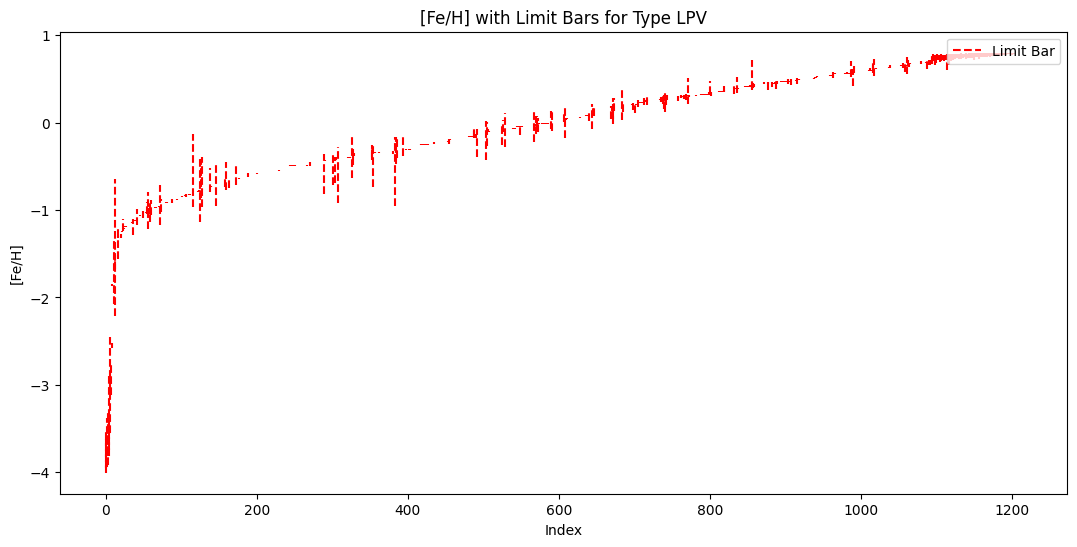

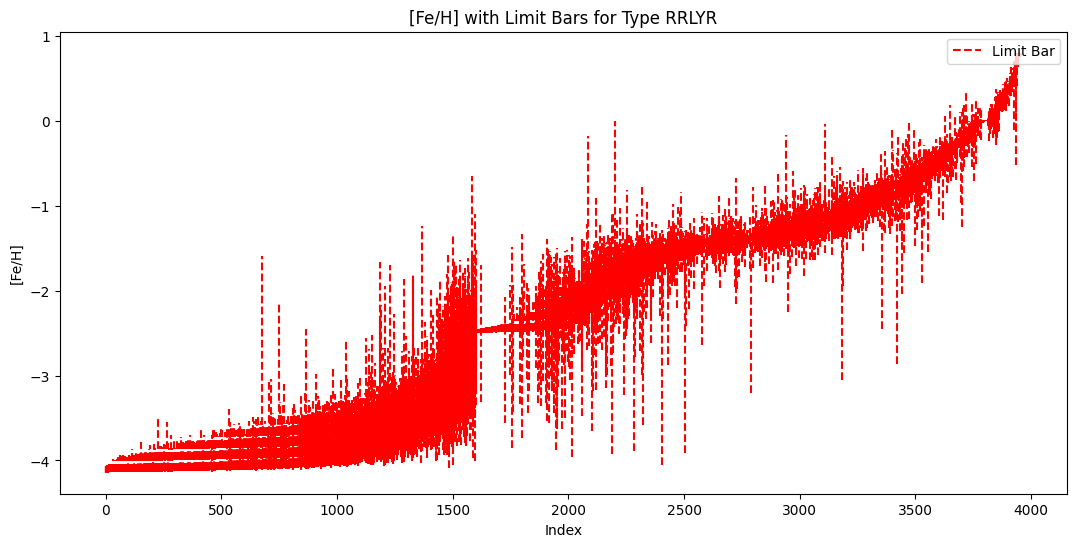

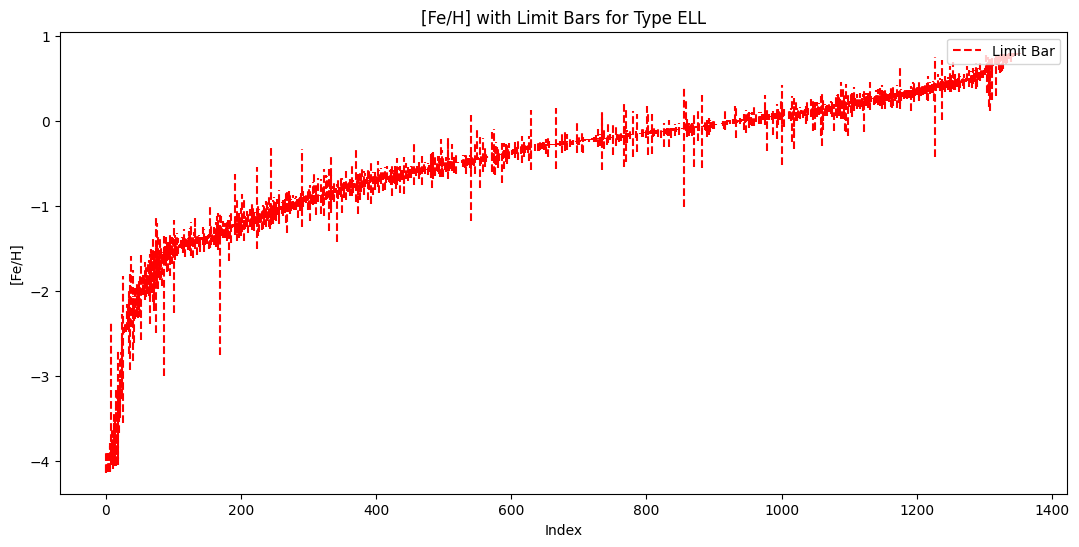

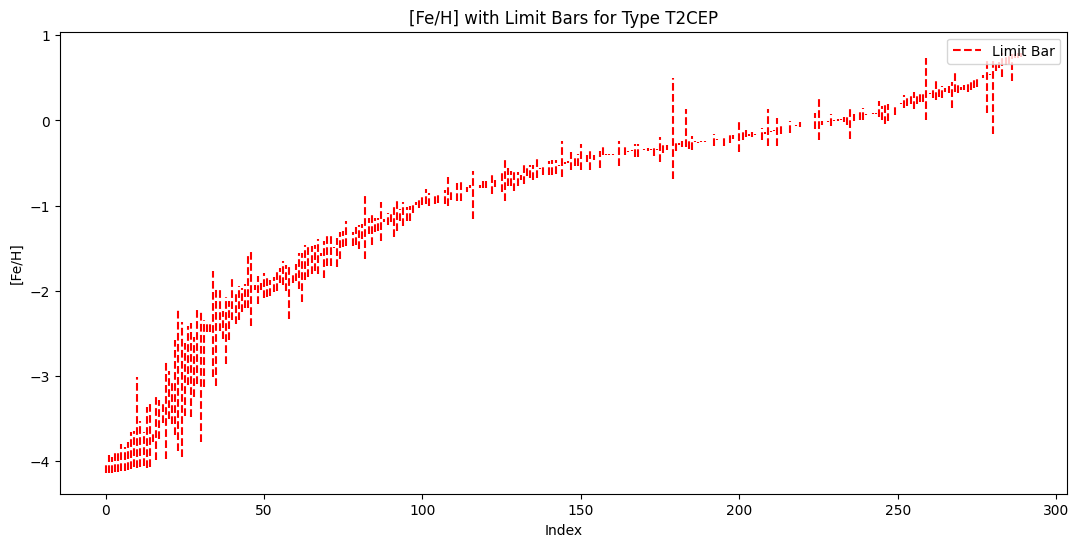

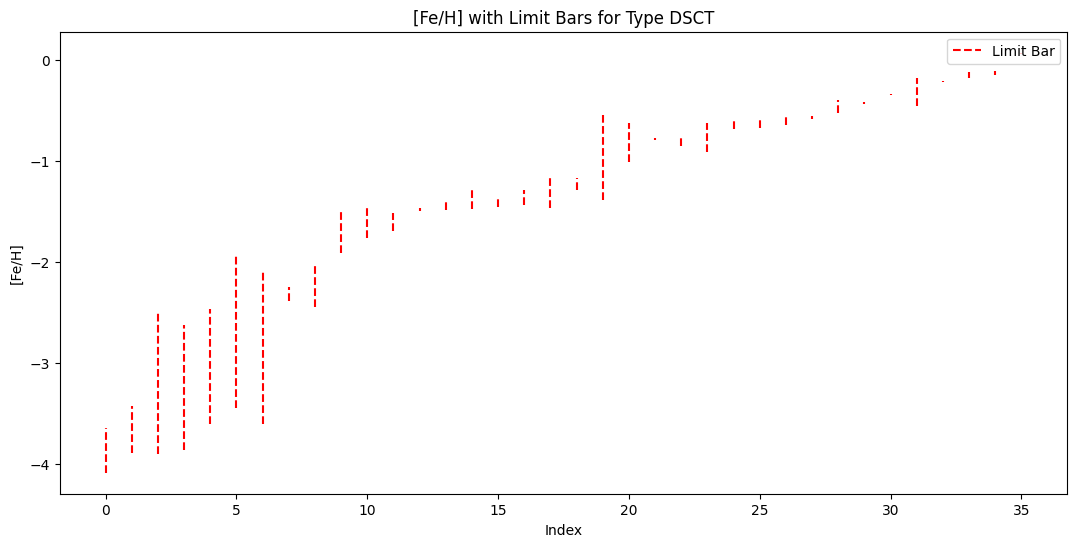

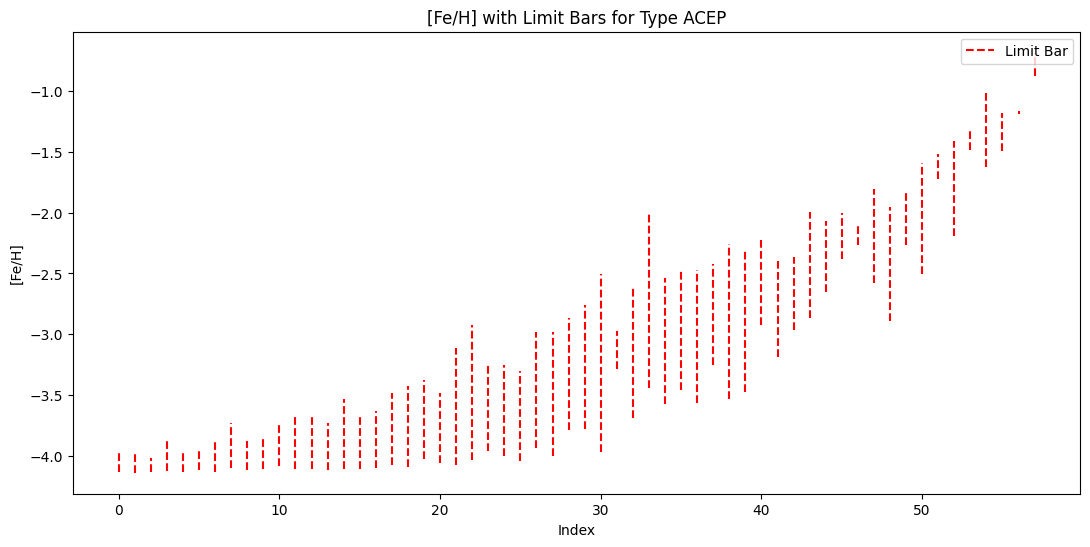

In [111]:
for classes in ['ECL', 'CEP', 'LPV', 'RRLYR', 'ELL', 'T2CEP', 'DSCT', 'ACEP']: 
    plot_error(meta2, column='[Fe/H]', lower_column='b_[Fe/H]_x', upper_column='B_[Fe/H]_xa', type=classes)

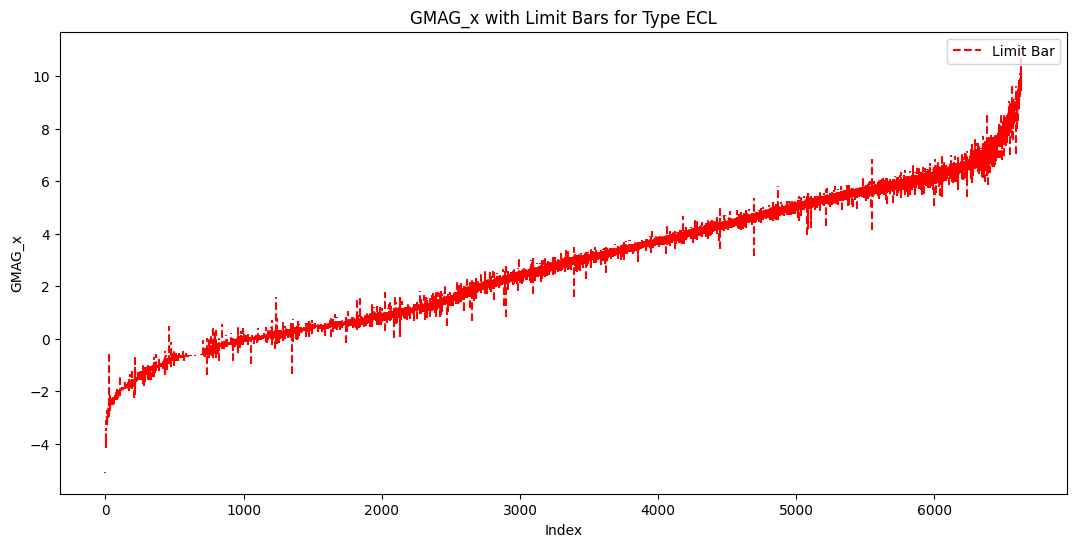

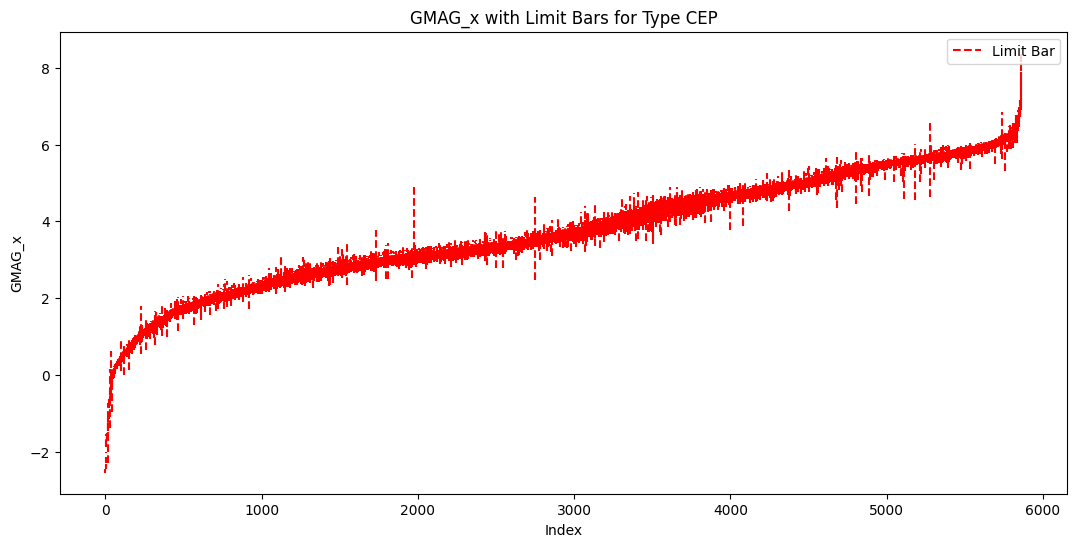

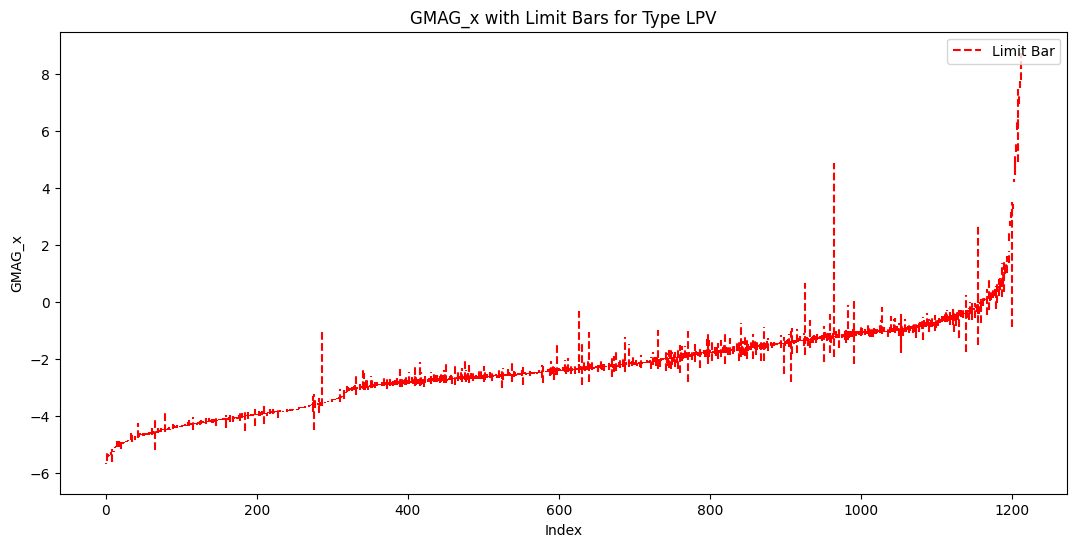

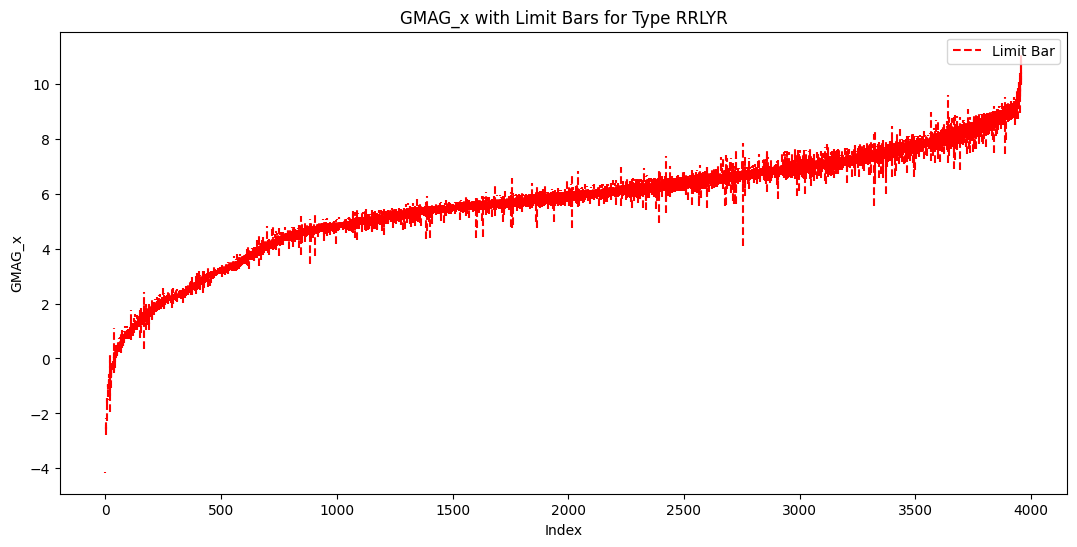

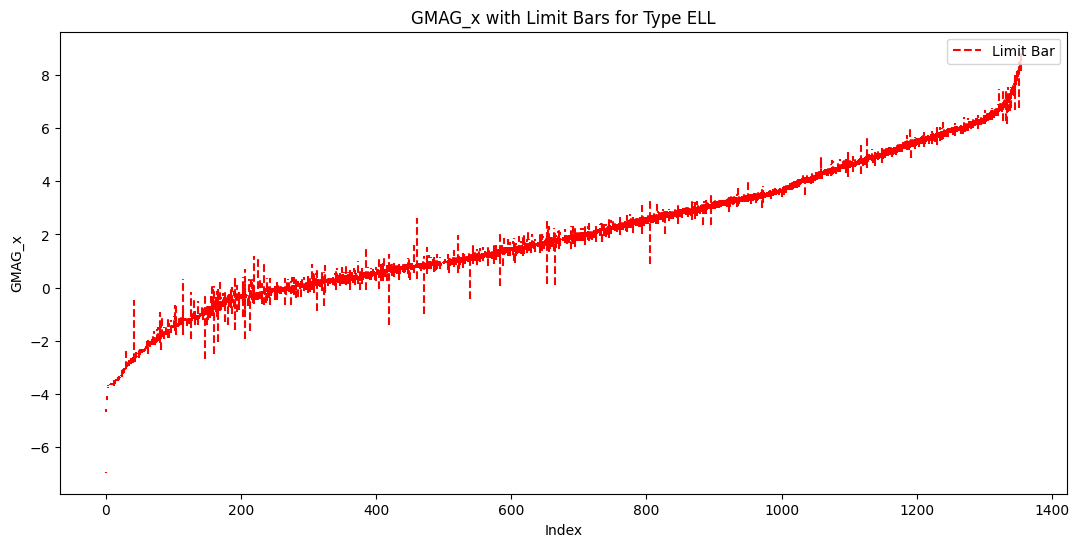

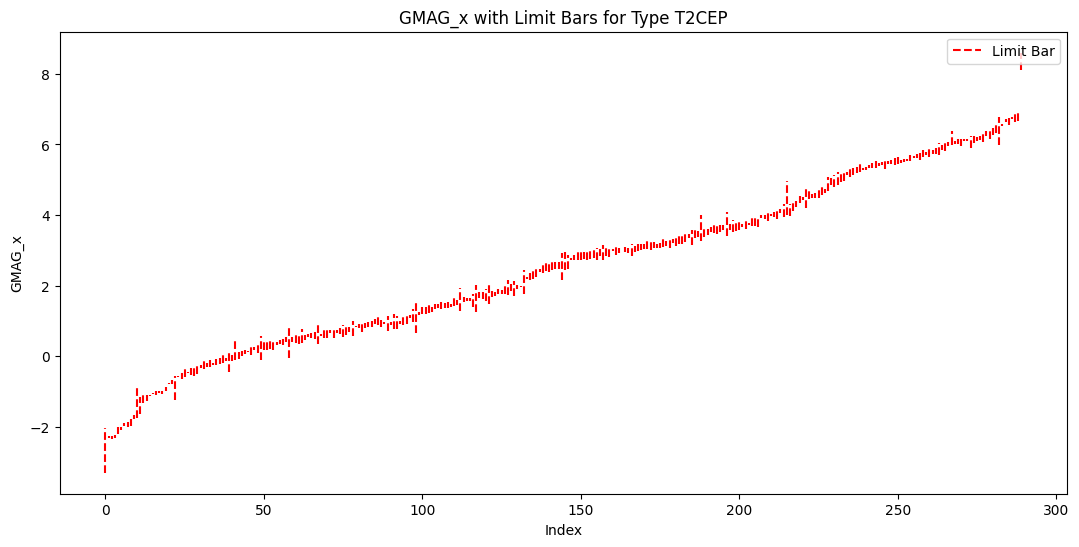

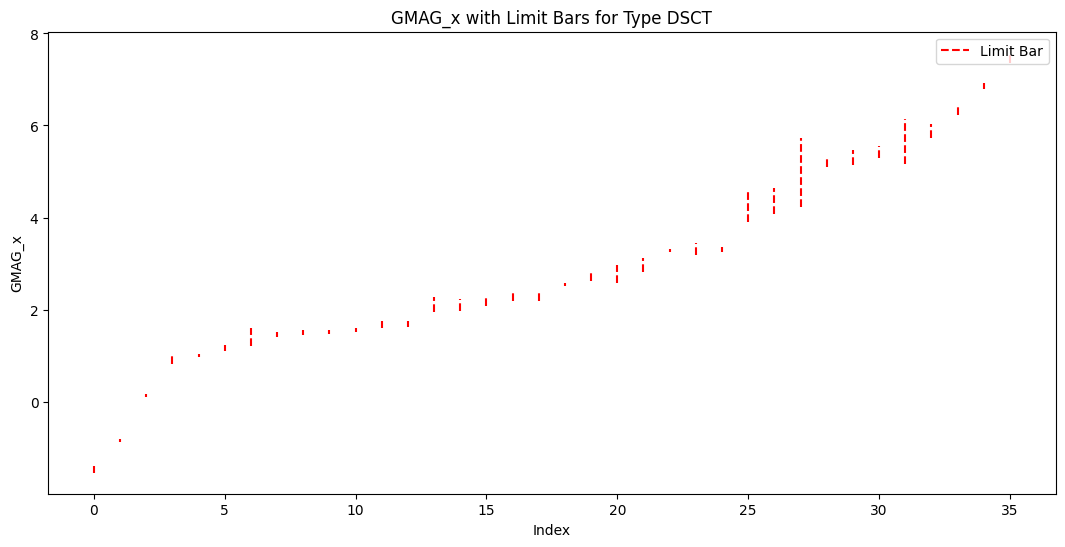

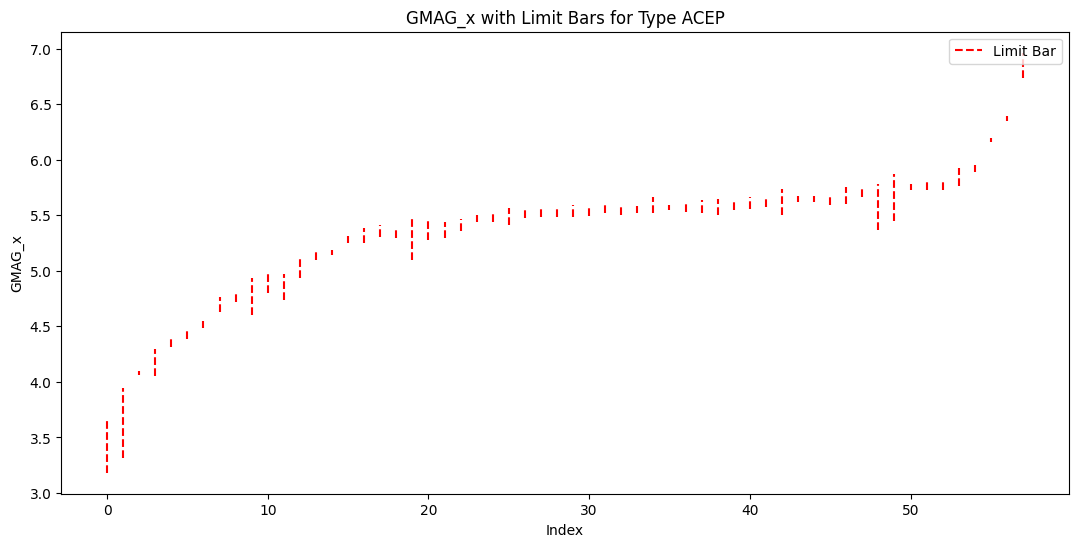

In [112]:
for classes in ['ECL', 'CEP', 'LPV', 'RRLYR', 'ELL', 'T2CEP', 'DSCT', 'ACEP']: 
    plot_error(meta2, column='GMAG_x', lower_column='b_GMAG_x', upper_column='B_GMAG_xa', type=classes)

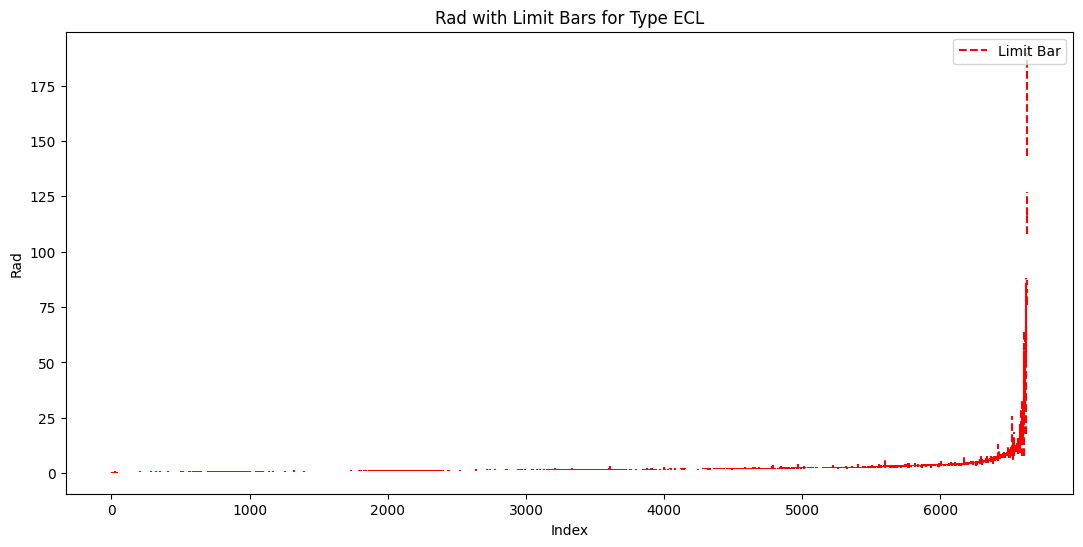

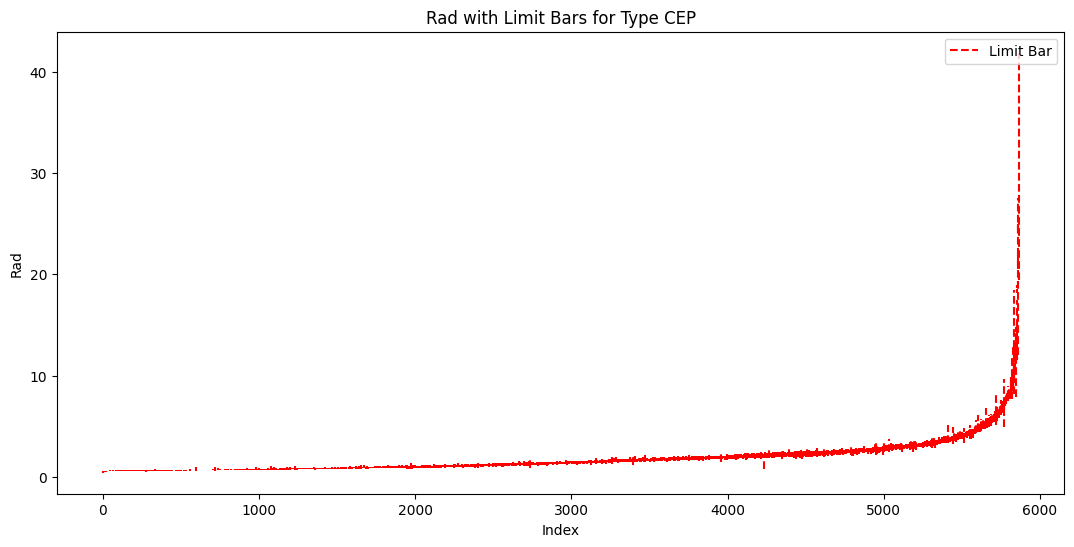

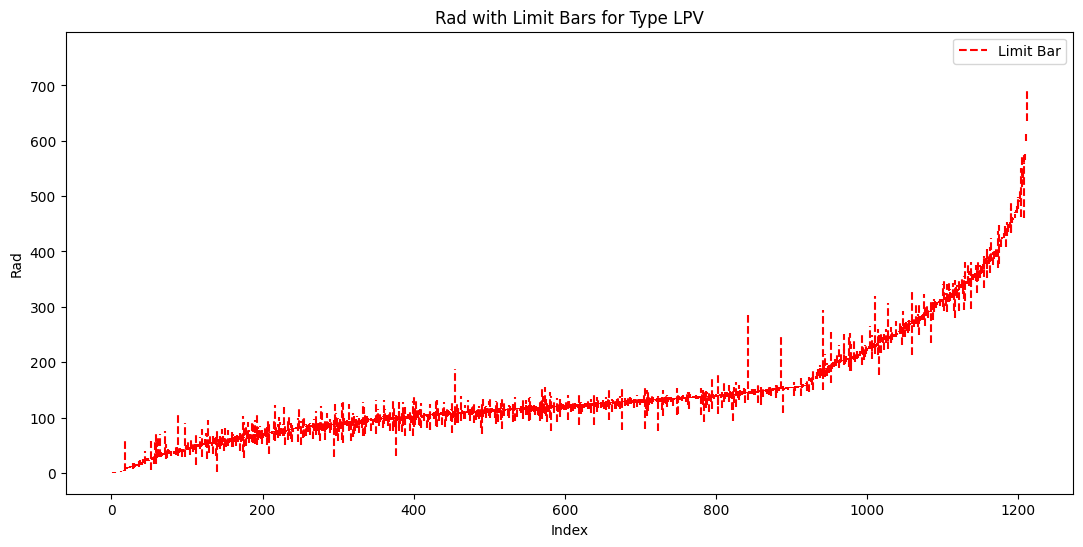

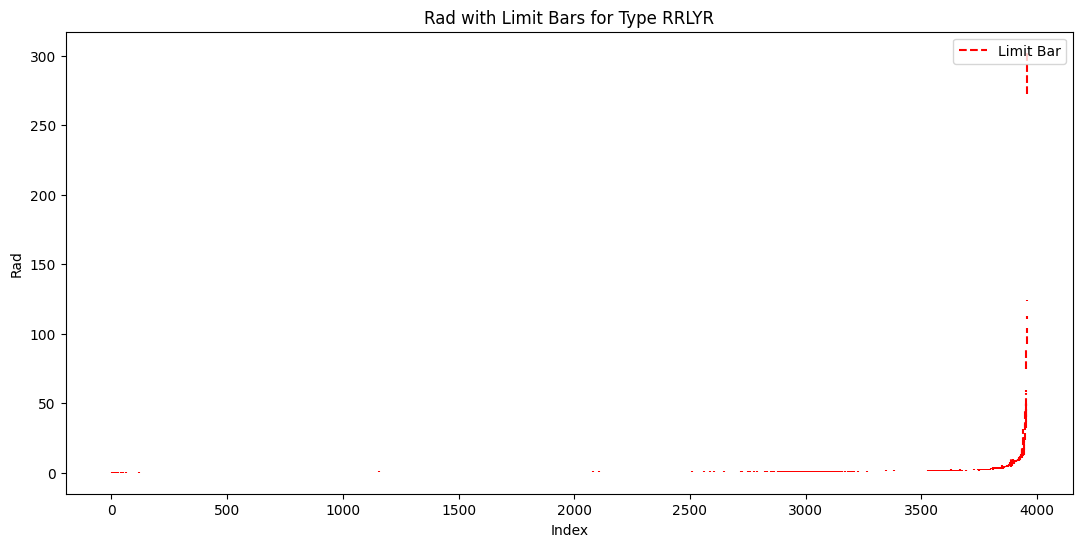

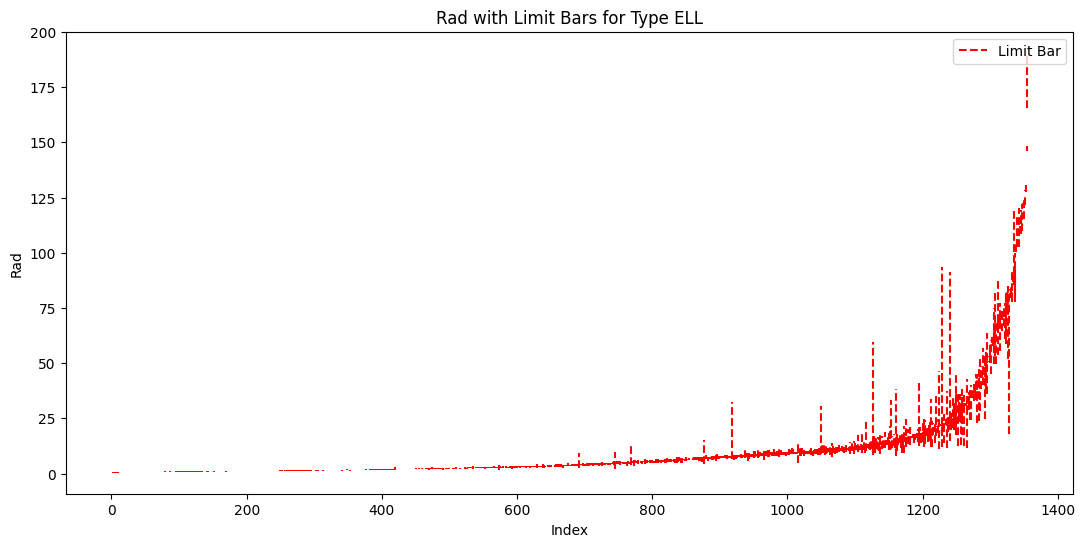

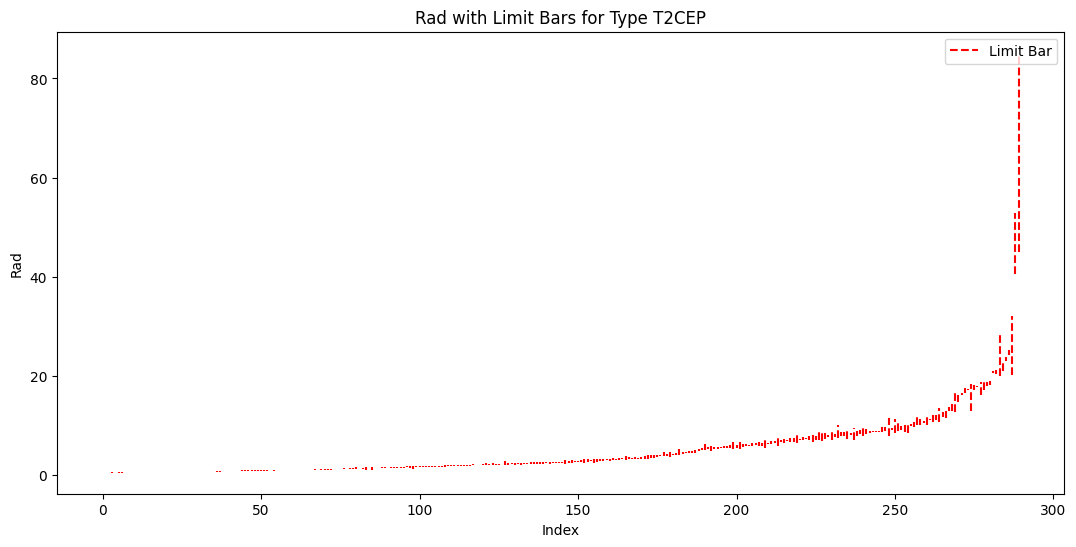

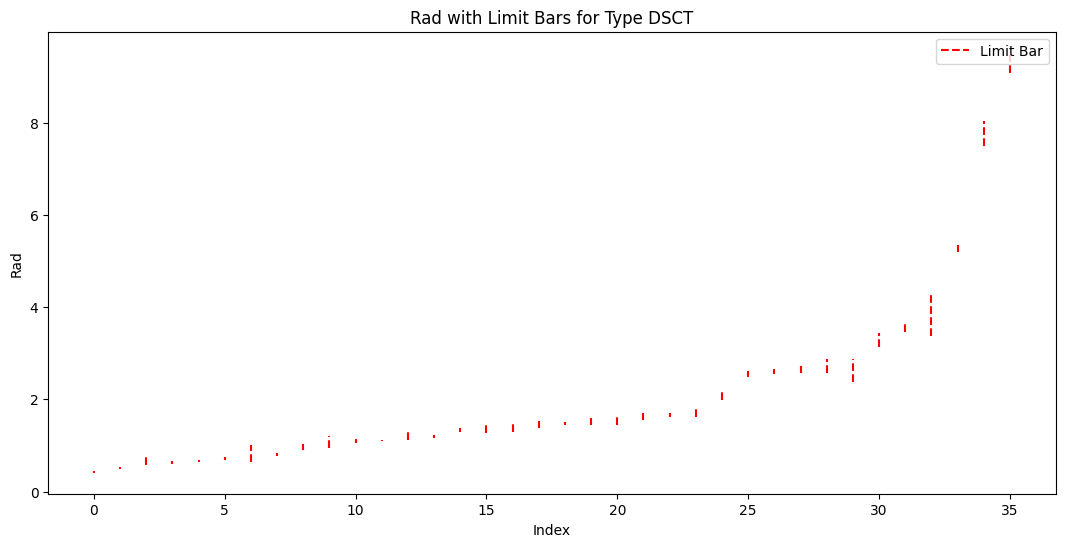

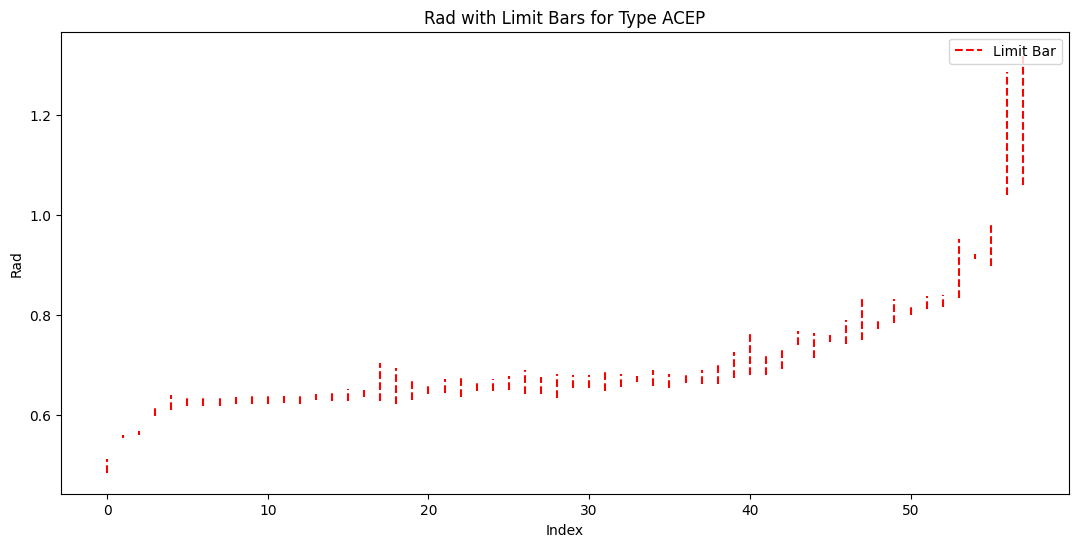

In [113]:
for classes in ['ECL', 'CEP', 'LPV', 'RRLYR', 'ELL', 'T2CEP', 'DSCT', 'ACEP']: 
    plot_error(meta2, column='Rad', lower_column='b_Rad_x', upper_column='B_Rad_xa', type=classes)

In [5]:
meta1, lcs, data = load_data_to_train()


Loading from:
 /home/franciscoperez/Documents/GitHub/CNN-PELSVAE2/cnn-pels-vae/data/time_series/real/OGLE3_lcs_I_meta_snr5_augmented_folded_trim600.npy.gz


array([[[1.1097110e-03, 1.7700790e+01, 1.8999999e-02],
        [3.2942146e-03, 1.7631012e+01, 2.3000000e-02],
        [1.5009778e-02, 1.7589676e+01, 2.1000000e-02],
        ...,
        [1.9796976e+00, 1.7680084e+01, 2.1000000e-02],
        [1.9859014e+00, 1.7645636e+01, 1.8999999e-02],
        [1.9958012e+00, 1.7607756e+01, 2.1000000e-02]],

       [[3.9509867e-04, 1.7404615e+01, 1.4000000e-02],
        [4.9105141e-04, 1.7433239e+01, 1.5000000e-02],
        [5.2019125e-03, 1.7439070e+01, 1.4000000e-02],
        ...,
        [1.9868407e+00, 1.7420263e+01, 9.9999998e-03],
        [1.9874557e+00, 1.7418873e+01, 2.0000000e-02],
        [1.9939404e+00, 1.7472292e+01, 1.4000000e-02]],

       [[5.1106387e-03, 1.7273479e+01, 2.1000000e-02],
        [5.5310233e-03, 1.7175858e+01, 1.8999999e-02],
        [8.6920988e-03, 1.7164326e+01, 1.4000000e-02],
        ...,
        [1.9941753e+00, 1.7124809e+01, 1.4000000e-02],
        [1.9957510e+00, 1.7153591e+01, 1.7999999e-02],
        [1.9977432e+00

In [6]:
lcs[0]

array([[1.1097110e-03, 1.7700790e+01, 1.8999999e-02],
       [3.2942146e-03, 1.7631012e+01, 2.3000000e-02],
       [1.5009778e-02, 1.7589676e+01, 2.1000000e-02],
       ...,
       [1.9796976e+00, 1.7680084e+01, 2.1000000e-02],
       [1.9859014e+00, 1.7645636e+01, 1.8999999e-02],
       [1.9958012e+00, 1.7607756e+01, 2.1000000e-02]], dtype=float32)

In [13]:
np.max(lcs[0, :, 0])

1.9958012

In [14]:
np.max(lcs[0, :, 1])

17.780333

In [15]:
np.max(lcs[0, :, 2])

0.025